# Oil Price Prediction

Oil is a product that goes completely in a different direction for a single market event as the oil
prices are rarely based on real-time data, instead, it is driven by externalities making our
attempt to forecast it even more challenging
As the economy will be highly affected by oil prices our model will help to understand the
pattern in prices to help the customers and businesses to make smart decisions.

Here we are using a dataset of New York Harbour Conventional Gasoline which is recorded on monthly basis since 1986.

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import kpss

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import StepwiseContext
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from pmdarima import model_selection
from math import sqrt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from statsmodels.tools.eval_measures import rmse

In [26]:
!pip install prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Exploratory Data Analysis

Skipping unnecessary rows in the dataset

In [27]:
gas = pd.read_csv('New_York_Harbor_Conventional_Gasoline_Regular_Spot_Price_FOB_Monthly (2).csv', skiprows=4)

In [28]:
gas.head(10)

Month  \
0  Oct 2023   
1  Sep 2023   
2  Aug 2023   
3  Jul 2023   
4  Jun 2023   
5  May 2023   
6  Apr 2023   
7  Mar 2023   
8  Feb 2023   
9  Jan 2023   

   New York Harbor Conventional Gasoline Regular Spot Price FOB Dollars per Gallon  
0                                              2.524                                
1                                              2.894                                
2                                              2.874                                
3                                              2.700                                
4                                              2.659                                
5                                              2.570                                
6                                              2.765                                
7                                              2.515                                
8                                              2.532                                
9                                              2.593

Renaming the price column

In [29]:
gas = gas.rename(columns={"New York Harbor Conventional Gasoline Regular Spot Price FOB Dollars per Gallon":"Dollars_per_Gallon"})

In [30]:
gas.head()

Month  Dollars_per_Gallon
0  Oct 2023               2.524
1  Sep 2023               2.894
2  Aug 2023               2.874
3  Jul 2023               2.700
4  Jun 2023               2.659

In [31]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Month               449 non-null    object 
 1   Dollars_per_Gallon  449 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.1+ KB


As we can see that the Month column is having dtype as object so let's convert it to a date-time object. Also it is having a format 'Jun-23', 'Jan-86' etc., hence we need to specify the format as well.

In [32]:
gas['Month'] = pd.to_datetime(gas['Month'])

In [33]:
gas.head()

Month  Dollars_per_Gallon
0 2023-10-01               2.524
1 2023-09-01               2.894
2 2023-08-01               2.874
3 2023-07-01               2.700
4 2023-06-01               2.659

In [34]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Month               449 non-null    datetime64[ns]
 1   Dollars_per_Gallon  449 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.1 KB


In [35]:
gas.describe().T

count      mean       std    min    25%    50%    75%  \
Dollars_per_Gallon  449.0  1.379795  0.869635  0.307  0.593  1.153  2.028   

                      max  
Dollars_per_Gallon  4.082

Let's sort the dataframe by Month column

In [36]:
gas = gas.sort_values(by='Month')

In [37]:
gas = gas.reset_index(drop=True)

In [38]:
gas.head()

Month  Dollars_per_Gallon
0 1986-06-01               0.420
1 1986-07-01               0.340
2 1986-08-01               0.426
3 1986-09-01               0.420
4 1986-10-01               0.410

In [39]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Month               449 non-null    datetime64[ns]
 1   Dollars_per_Gallon  449 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.1 KB


## Duplicates Check

In [40]:
gas[gas.duplicated()]

Empty DataFrame
Columns: [Month, Dollars_per_Gallon]
Index: []

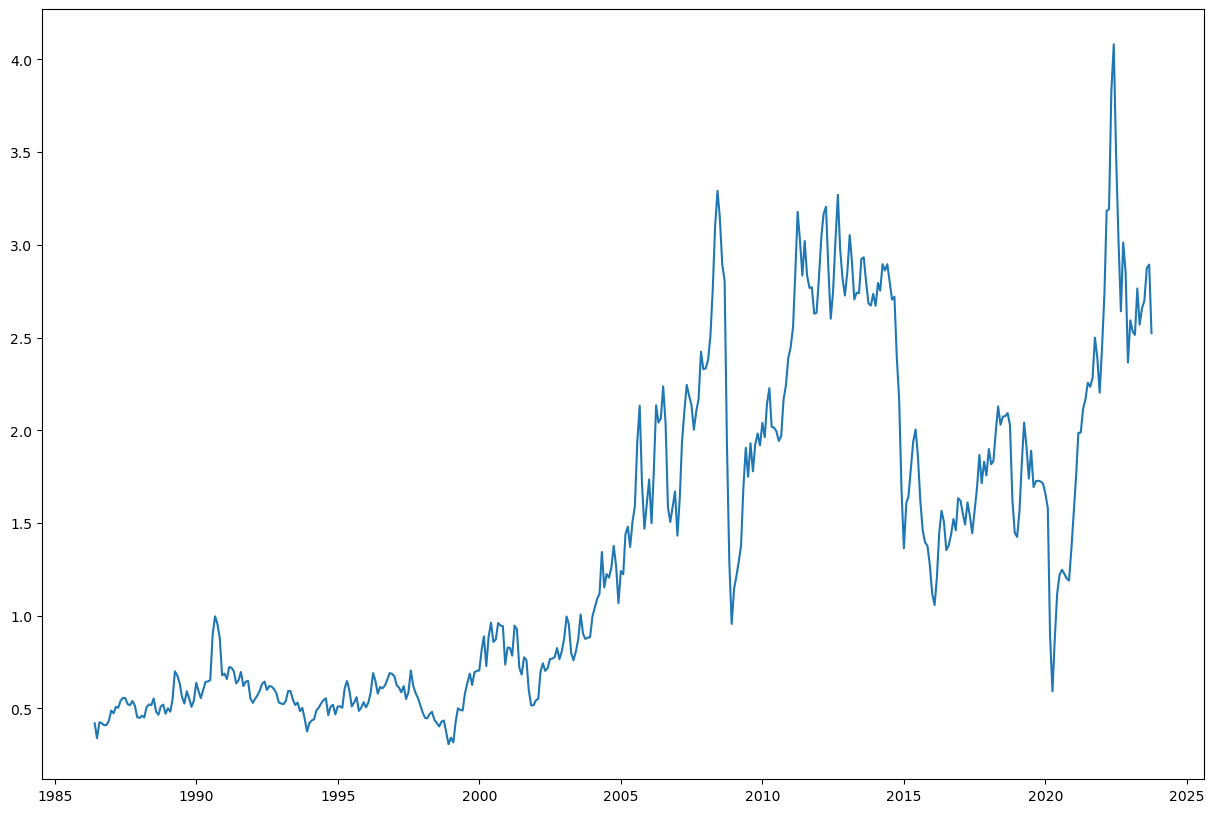

In [41]:
plt.figure(figsize = (15, 10))
plt.plot(gas['Month'],gas['Dollars_per_Gallon'])
plt.show()

In [42]:
gas["month"] = gas.Month.dt.strftime("%b") 
gas["year"] = gas.Month.dt.strftime("%Y") 

<Axes: xlabel='month', ylabel='year'>

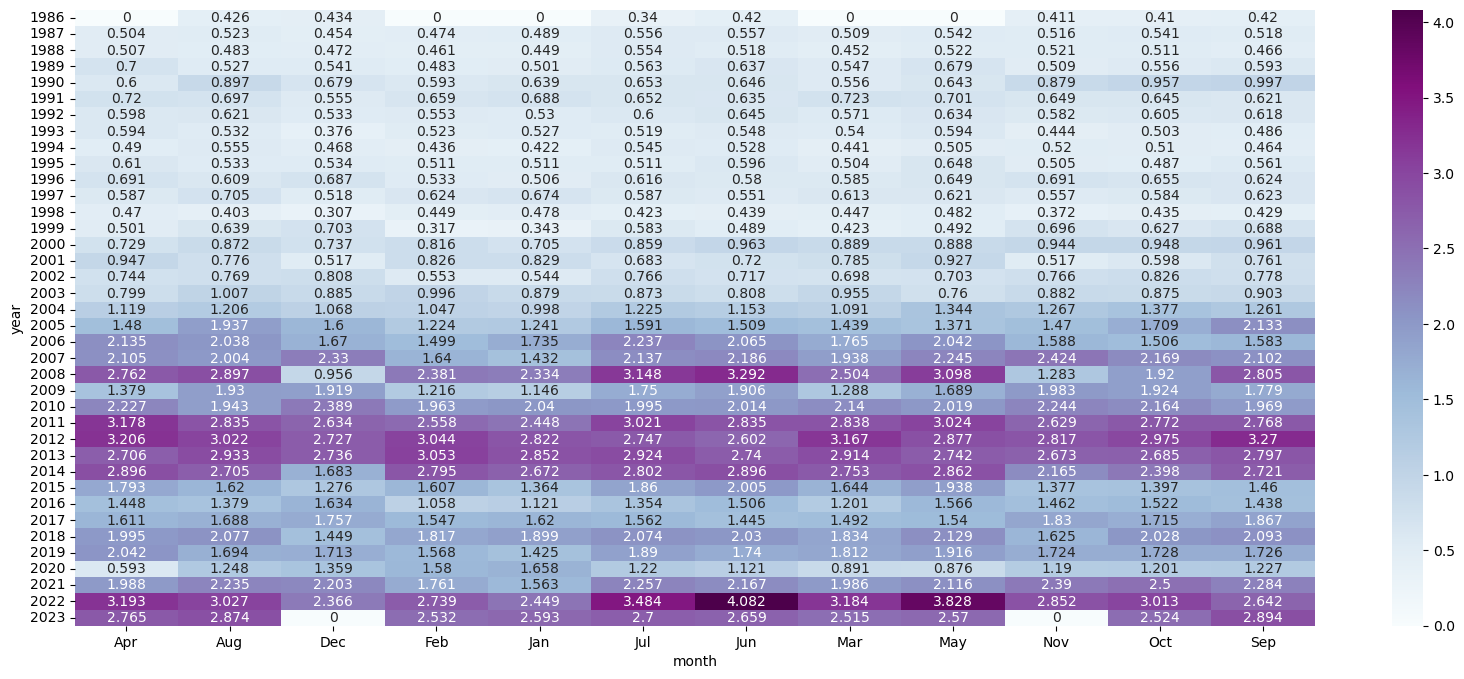

In [43]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=gas,values='Dollars_per_Gallon',index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g",cmap='BuPu') #fmt is format of the grid values

In [44]:
gas = gas.drop(columns={'month','year'})

<Axes: >

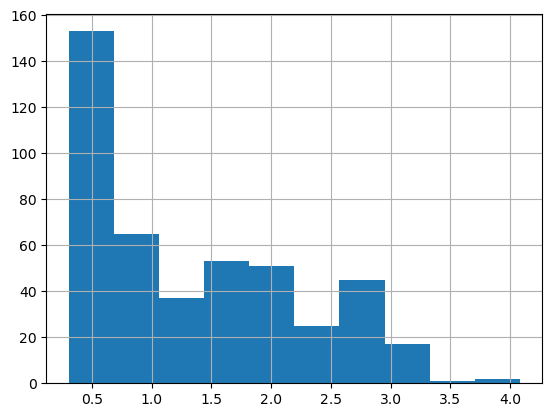

In [45]:
gas['Dollars_per_Gallon'].hist()

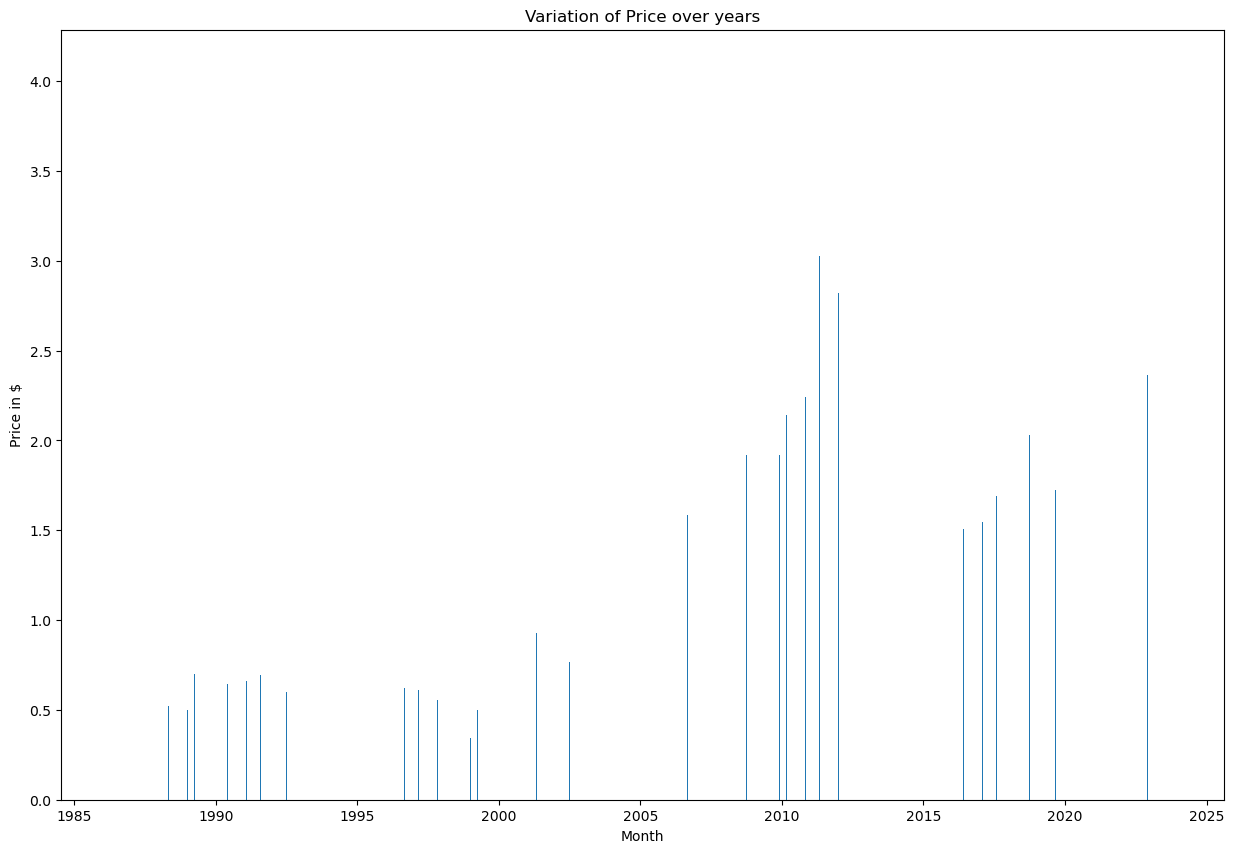

In [46]:
plt.figure(figsize=(15,10))
x=gas['Month']
y=gas['Dollars_per_Gallon']
plt.bar(x,y)
plt.title('Variation of Price over years')
plt.xlabel('Month')
plt.ylabel('Price in $')
plt.show()

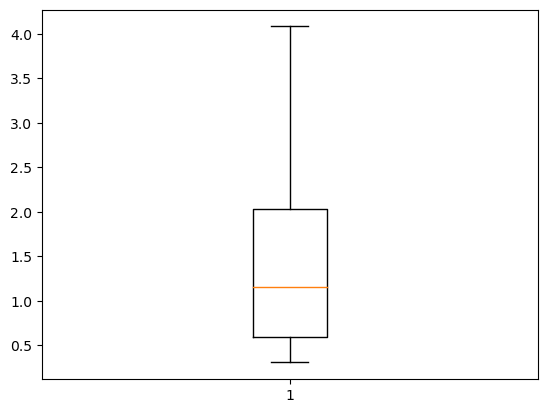

In [47]:
box=plt.boxplot(gas['Dollars_per_Gallon'])

## Box Plots of Each Year by Monthly Intervals

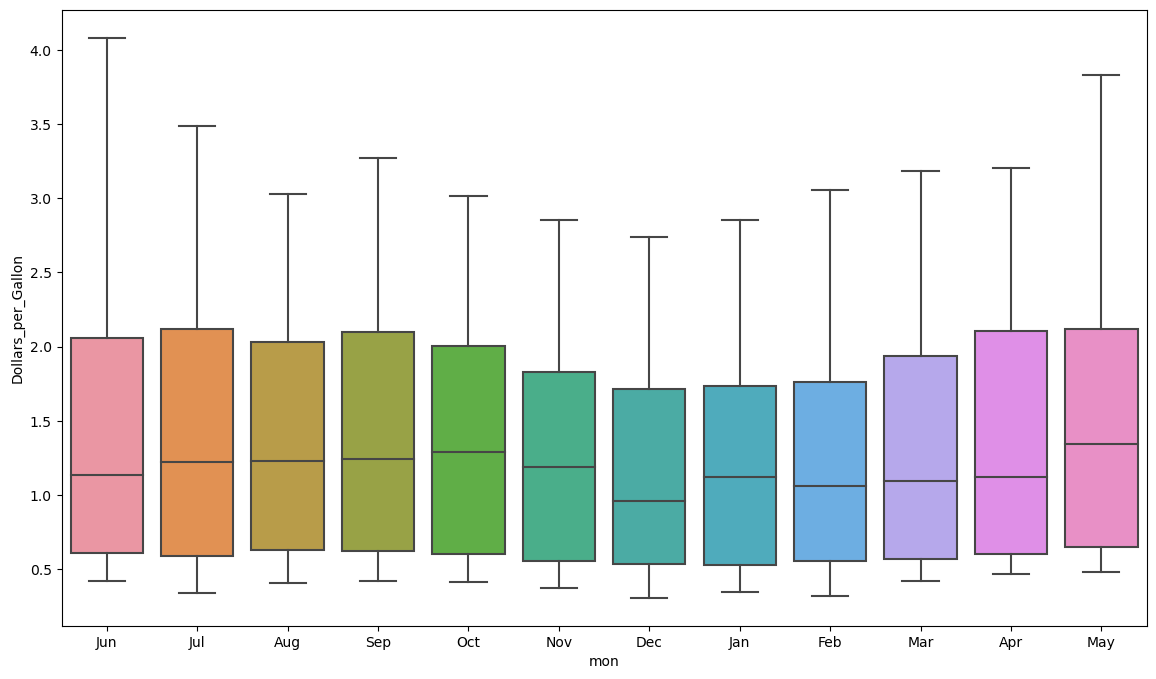

In [48]:
gas['mon'] = gas.Month.dt.strftime("%b")
plt.figure(figsize=(14,8))
sns.boxplot(x='mon',y='Dollars_per_Gallon',data=gas)
gas = gas.drop(columns='mon')

## Lag Plot 

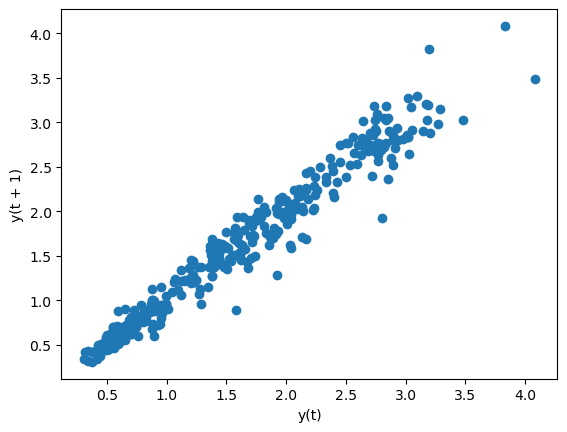

In [49]:
lag_plot(gas['Dollars_per_Gallon'])
plt.show()

From the Lag plot we can say that there is good correlation to the lagged versions of itself 

## ACF Plot 

<Figure size 1000x1500 with 0 Axes>

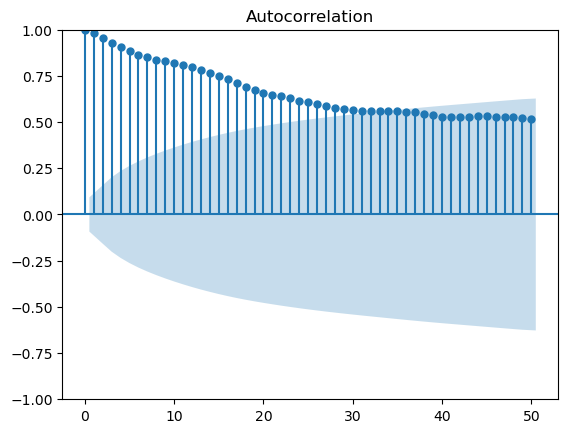

In [50]:
plt.figure(figsize = (10, 15))
plot_acf(gas['Dollars_per_Gallon'], lags=50)
plt.show()

## PACF Plot

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x1500 with 0 Axes>

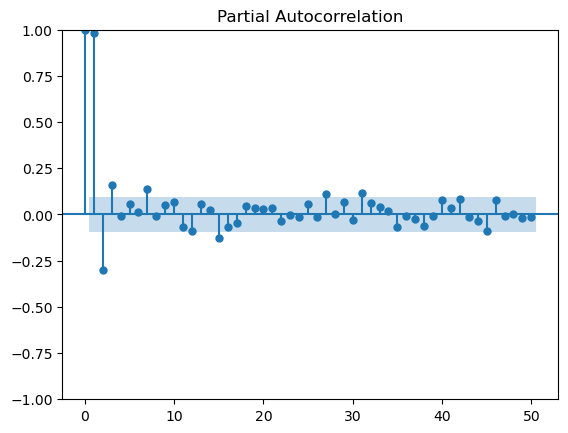

In [51]:
plt.figure(figsize = (10, 15))
plot_pacf(gas['Dollars_per_Gallon'], lags=50)
plt.show()

We can see that the data is having a sharp cutoff after the second lag in the PACF plot whereas in the ACF plot we are having a gradual decline. Hence implmenting a MA (Moving Average) Model will give us better results.

## Rolling Stats - Moving Average

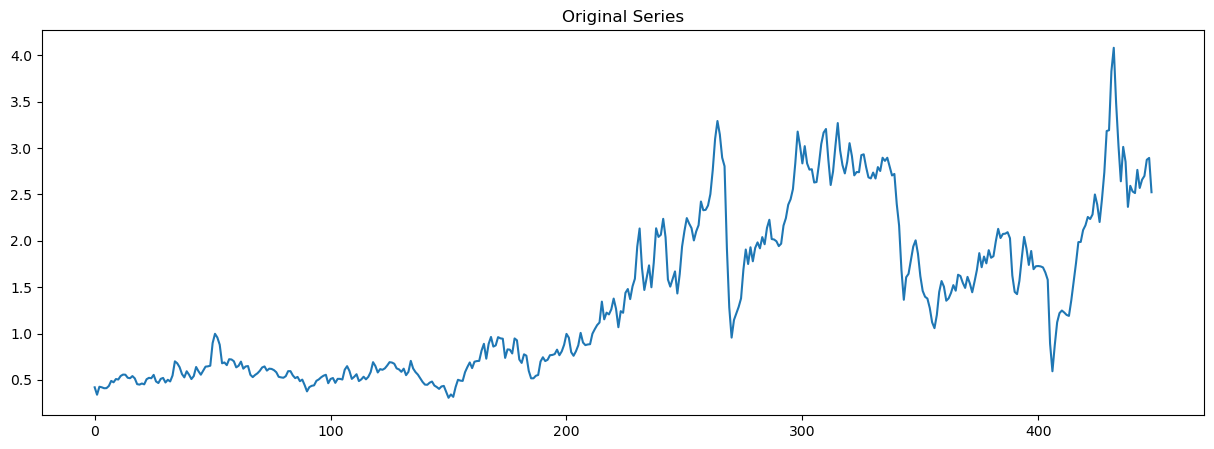

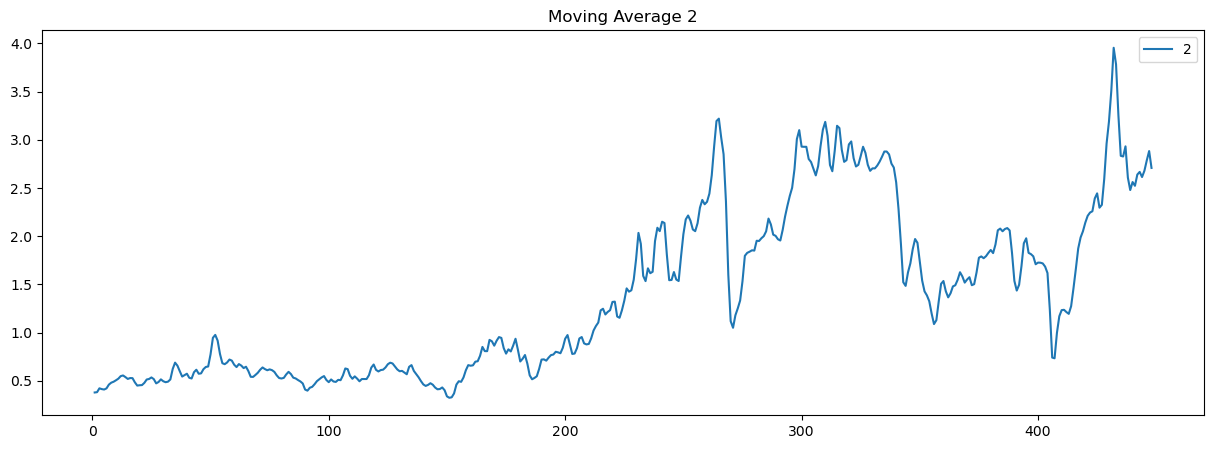

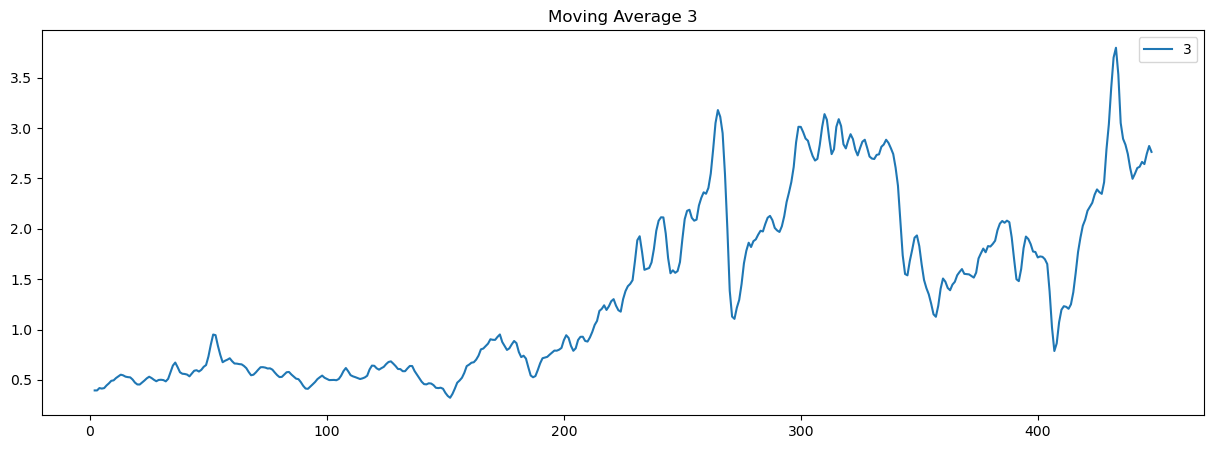

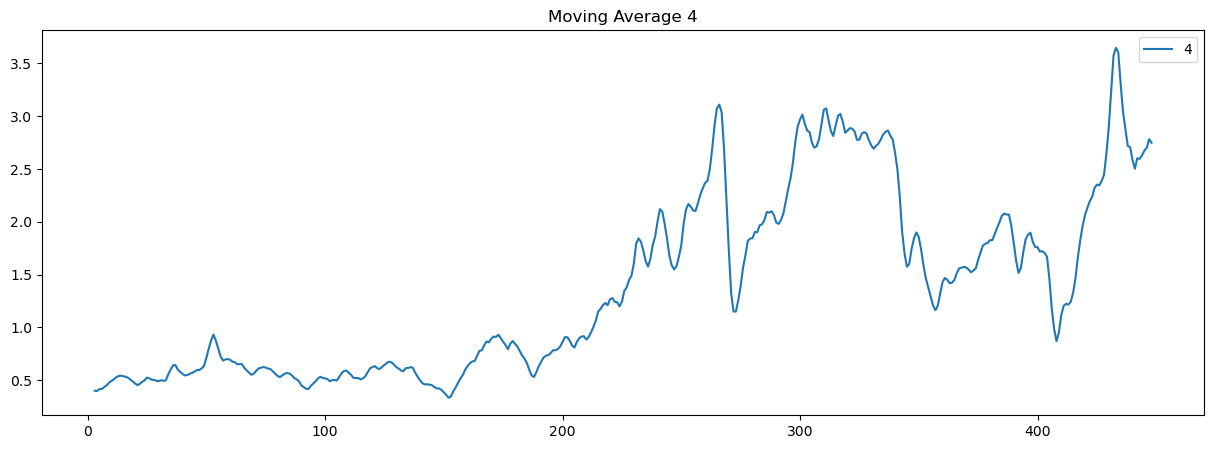

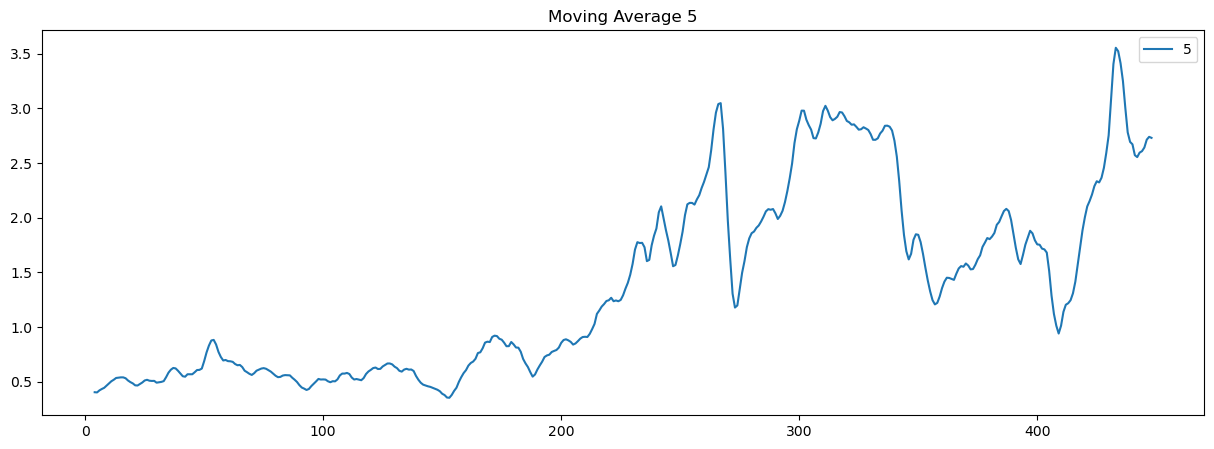

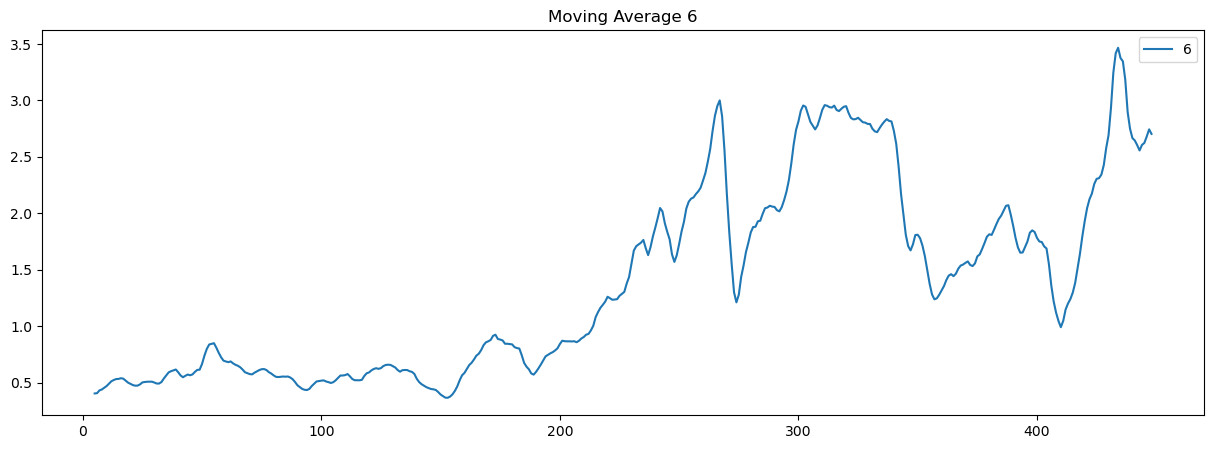

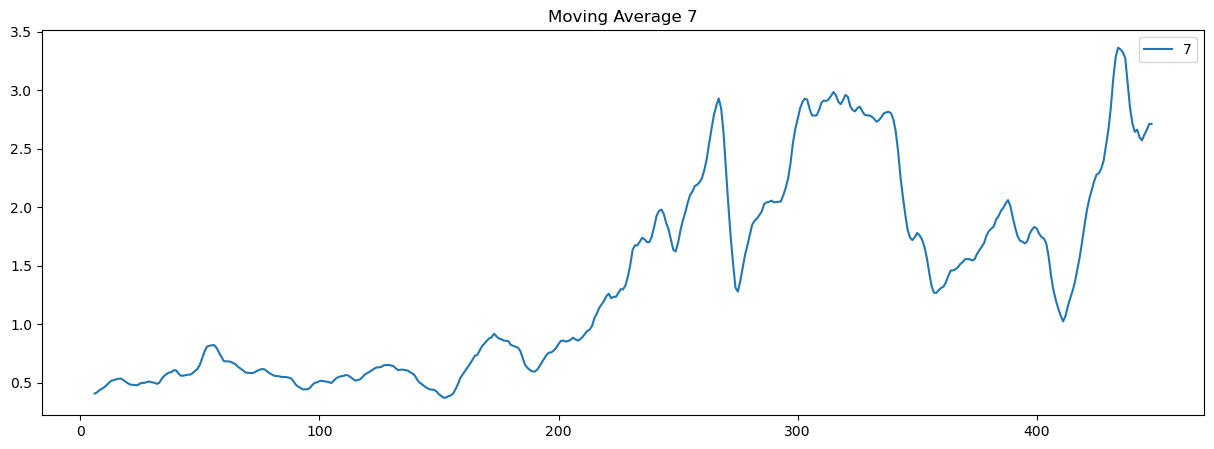

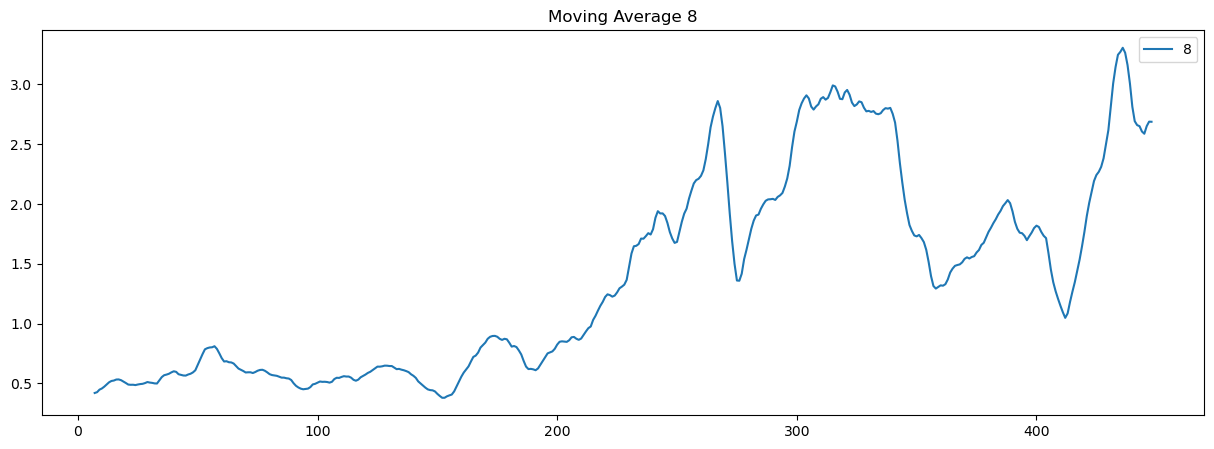

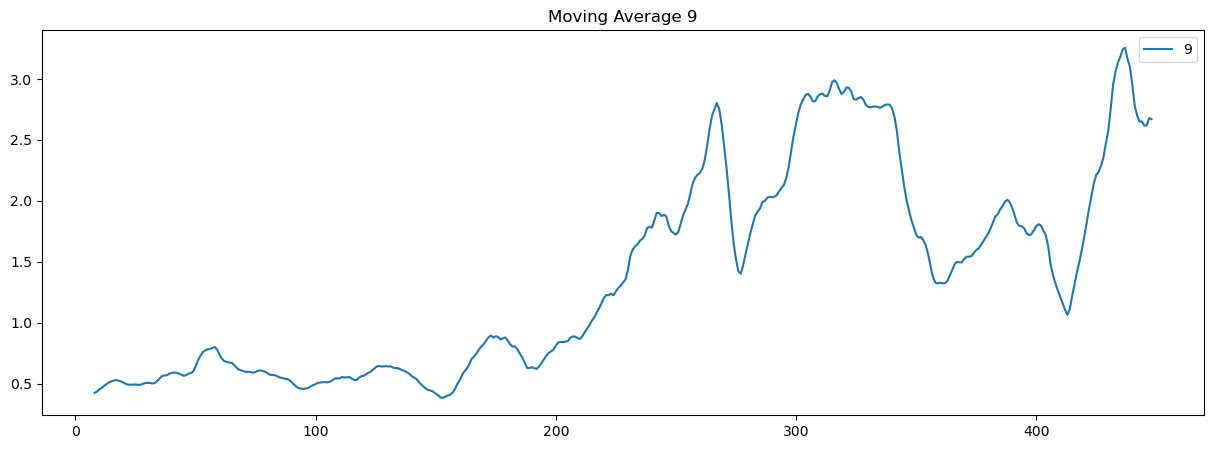

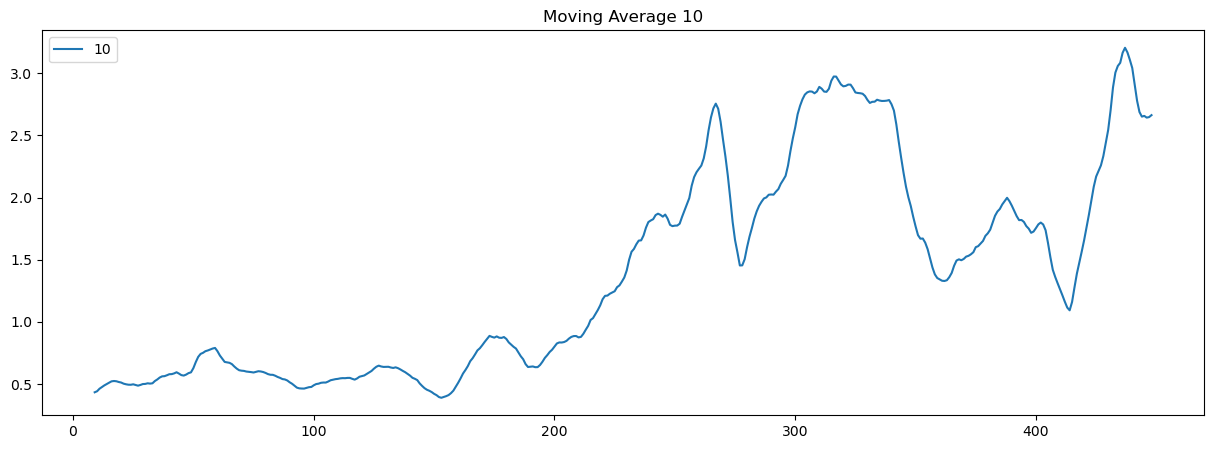

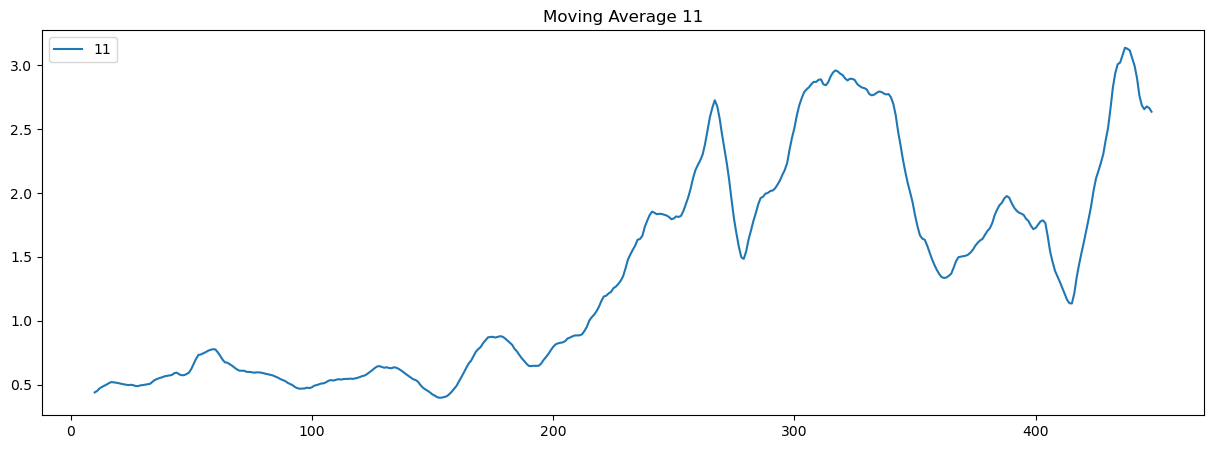

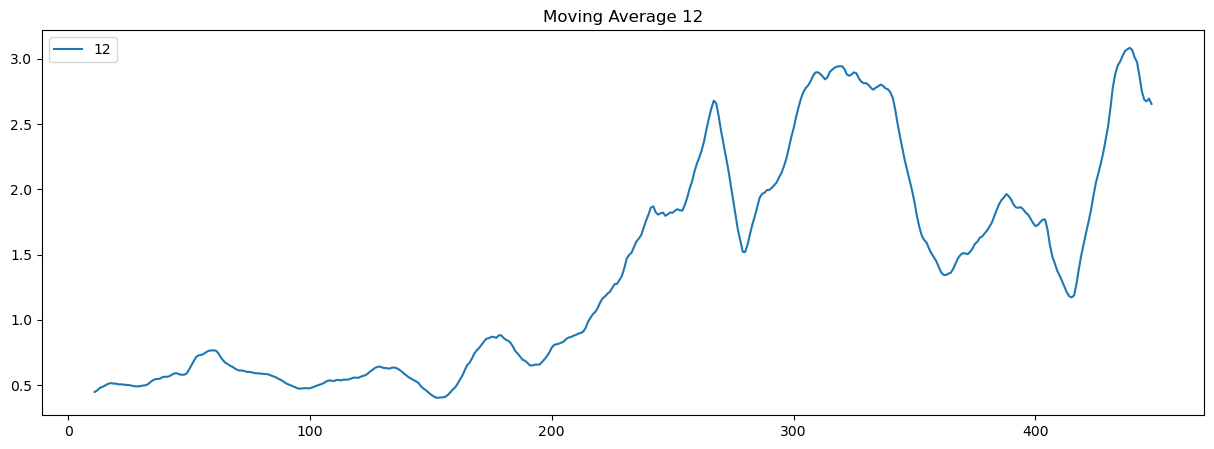

In [52]:
plt.figure(figsize=(15,5))
gas['Dollars_per_Gallon'].plot()
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(15,5))
    gas['Dollars_per_Gallon'].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

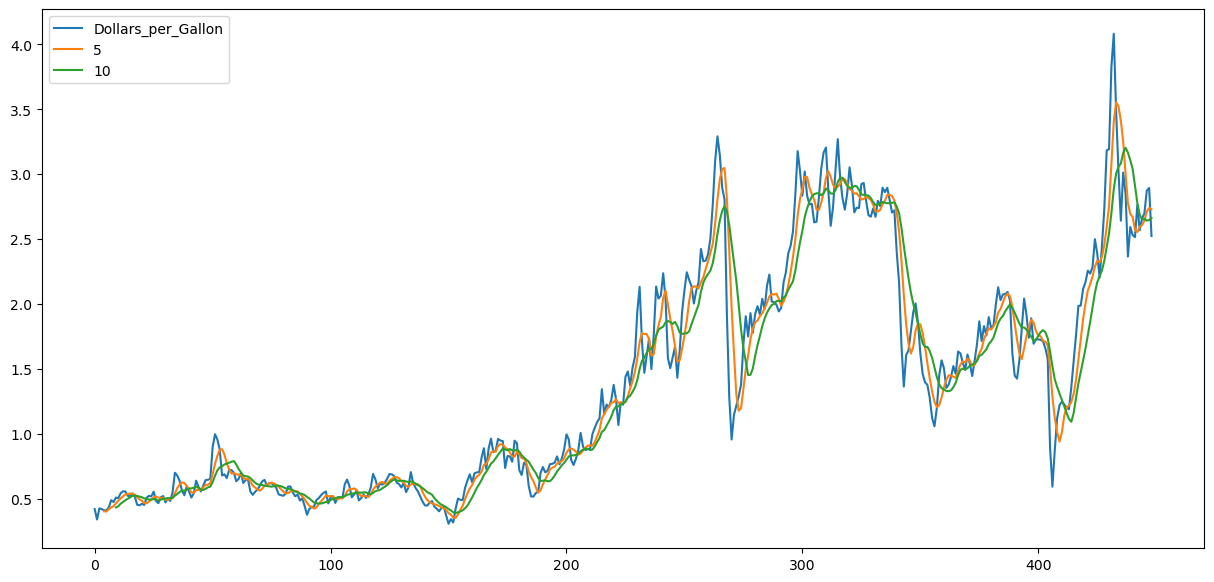

In [53]:
plt.figure(figsize=(15,7))
gas['Dollars_per_Gallon'].plot()
for i in range(5,13,5):
    gas['Dollars_per_Gallon'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

## Seasonal Decomposition 

In [54]:
result = seasonal_decompose(gas['Dollars_per_Gallon'], model='multiplicative', period=50)

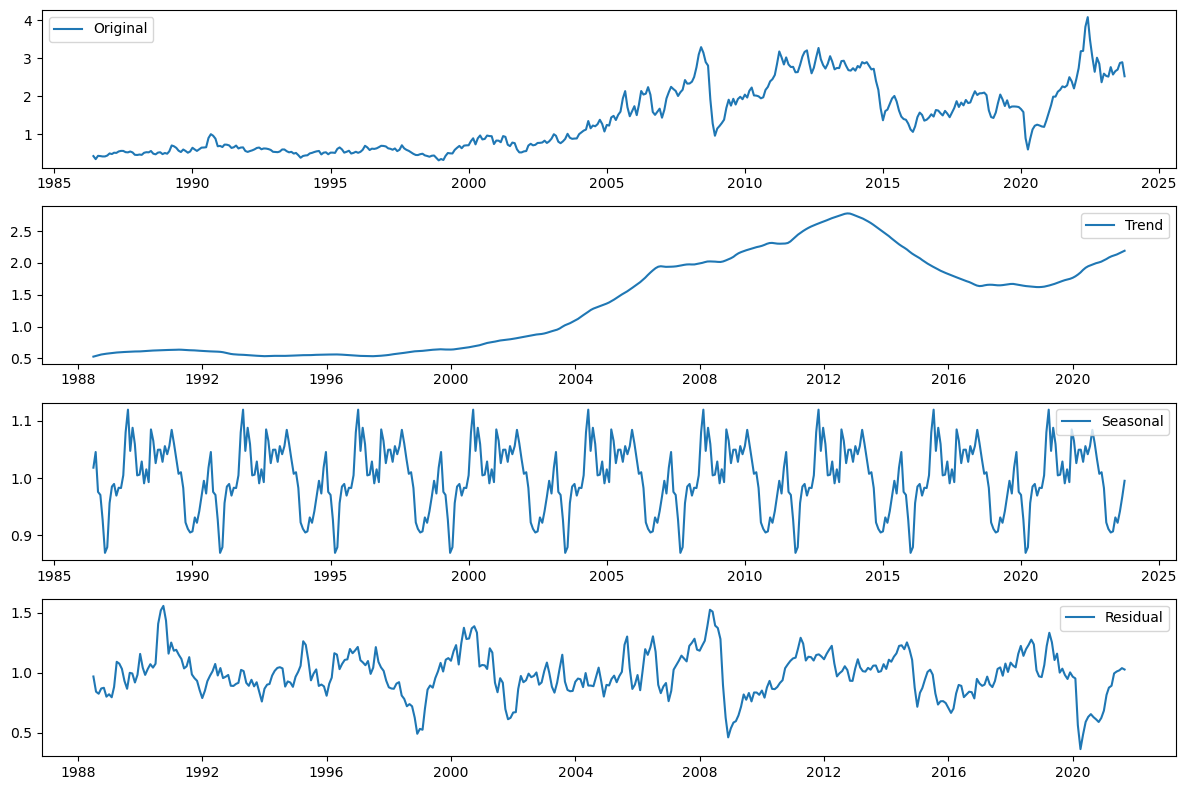

In [55]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(gas.Month, gas['Dollars_per_Gallon'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(gas.Month, result.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(gas.Month, result.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(gas.Month, result.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

As we can see that there is change in amplitude of the seasonal component with respect to the trend.

In the Seasonal graph, we can see that there is a pattern being repeated once in every 5 years.

In [56]:
dftest = adfuller(gas.Dollars_per_Gallon)
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.4552384410254073
2. P-Value :  0.5555267352047539
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 438
5. Critical Values :
	 1% :  -3.445368352170937
	 5% :  -2.8681614049724002
	 10% :  -2.570296970872167


Since the p-value is greater than the significance level of 0.05, we have evidence to support the null hypothesis. This further indicates that <b>the time series is non-stationary</b>.

We need to apply some techniques to convert this non-stationary data to stationary data

## Transformations

In [57]:
gas['Dollar_Log'] = np.log(gas['Dollars_per_Gallon'])

gas['Dollar_Sqrt'] = np.sqrt(gas['Dollars_per_Gallon'])

gas['Dollar_Cbrt'] = np.cbrt(gas['Dollars_per_Gallon'])

<Axes: >

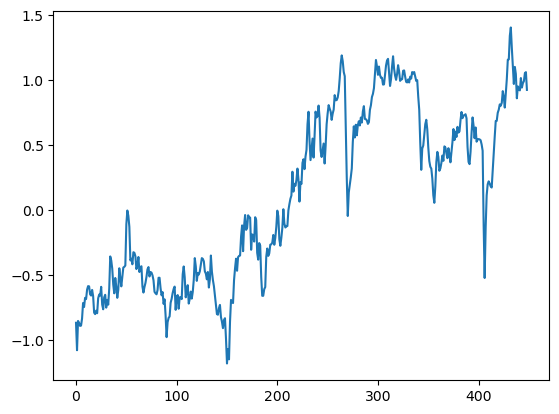

In [58]:
gas['Dollar_Log'].plot()

<Axes: >

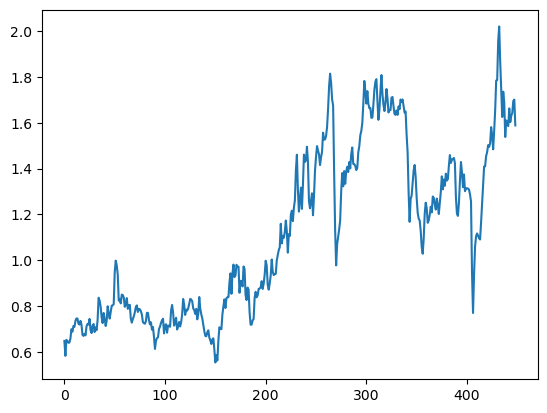

In [59]:
gas['Dollar_Sqrt'].plot()

<Axes: >

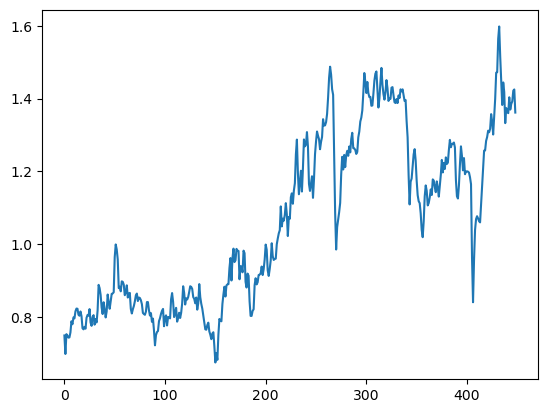

In [60]:
gas['Dollar_Cbrt'].plot()

In [61]:
dftest = adfuller(gas.Dollar_Log)
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.723448655997776
2. P-Value :  0.41907331172029205
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 446
5. Critical Values :
	 1% :  -3.4450973903602367
	 5% :  -2.868042229965336
	 10% :  -2.570233448893


In [62]:
dftest = adfuller(gas.Dollar_Cbrt)
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.7664410703970597
2. P-Value :  0.3972453928211558
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 446
5. Critical Values :
	 1% :  -3.4450973903602367
	 5% :  -2.868042229965336
	 10% :  -2.570233448893


In [63]:
dftest = adfuller(gas.Dollar_Sqrt)
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.4441028982030344
2. P-Value :  0.5609596895831744
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 442
5. Critical Values :
	 1% :  -3.445231637930579
	 5% :  -2.8681012763264233
	 10% :  -2.5702649212751583


In [64]:
gas = gas.drop(columns=['Dollar_Sqrt','Dollar_Cbrt','Dollar_Log'])

Since these techniques didn't work we need to go for Differencing and Seasonal Differencing Techniques

## Differencing

From PACF Plot, We concluded that there is a strong correlation with its Lagged-1 version hence let us check with shift-1

In [65]:
gas['Dollar_Diff'] = gas['Dollars_per_Gallon'] - gas['Dollars_per_Gallon'].shift(1)

In [66]:
last_observed_value = gas['Dollars_per_Gallon'].iloc[-1]

<Axes: >

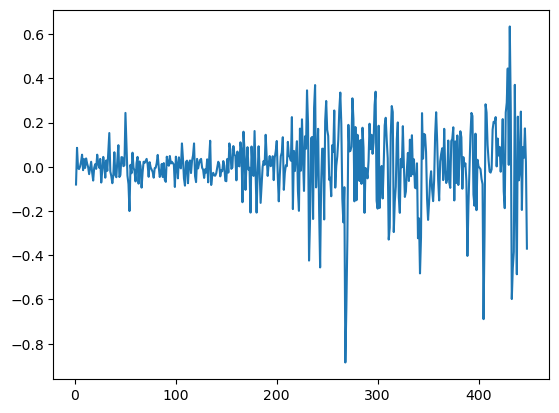

In [67]:
gas['Dollar_Diff'].dropna().plot()

## ADF Test

In [68]:
dftest = adfuller(gas.Dollar_Diff.dropna())
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -7.643963673024528
2. P-Value :  1.863848431226506e-11
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 438
5. Critical Values :
	 1% :  -3.445368352170937
	 5% :  -2.8681614049724002
	 10% :  -2.570296970872167


From the ADF test we can say that the <b>time series is likely stationary</b>, which is an essential requirement for many time series analysis and modeling techniques.

## KPSS Test

In [69]:
kpss_stat, p_value, lags, critical_values = kpss(gas.Dollar_Diff.dropna(), nlags=1)
print('KPSS Statistic: ',kpss_stat)
print('P-value: ', p_value)
print('Critical Values: ', lags)
print('Lags Used: ', critical_values)

KPSS Statistic:  0.02367648443987646
P-value:  0.1
Critical Values:  1
Lags Used:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Given that the p-value is 0.1 (greater than 0.05), we may not reject the null hypothesis of stationarity around a deterministic trend. This result, along with the ADF test result indicating stationarity after differencing, suggests that differencing has likely made our time series stationary. The results from both <b>the ADF and KPSS tests seem to be consistent with each other, indicating that your differenced series is stationary</b>.

In [70]:
gas.set_index('Month', inplace=True)

In [71]:
gas.head()

Dollars_per_Gallon  Dollar_Diff
Month                                      
1986-06-01               0.420          NaN
1986-07-01               0.340       -0.080
1986-08-01               0.426        0.086
1986-09-01               0.420       -0.006
1986-10-01               0.410       -0.010

In [72]:
gas['Dollar_Diff'].fillna(gas['Dollar_Diff'].median(), inplace=True)

In [73]:
gas.head()

Dollars_per_Gallon  Dollar_Diff
Month                                      
1986-06-01               0.420        0.008
1986-07-01               0.340       -0.080
1986-08-01               0.426        0.086
1986-09-01               0.420       -0.006
1986-10-01               0.410       -0.010

In [74]:
gas_new = gas.drop(columns='Dollars_per_Gallon')

In [75]:
scaler = MinMaxScaler(feature_range=(0, 1))
gas_standardized_arr = scaler.fit_transform(gas_new.values.reshape(-1, 1))

In [76]:
gas_standardized_arr

array([[0.5875    ],
       [0.52960526],
       [0.63881579],
       [0.57828947],
       [0.57565789],
       [0.58289474],
       [0.59736842],
       [0.61842105],
       [0.57236842],
       [0.60526316],
       [0.57894737],
       [0.60723684],
       [0.59210526],
       [0.58157895],
       [0.56052632],
       [0.57894737],
       [0.59736842],
       [0.56578947],
       [0.54144737],
       [0.57894737],
       [0.59013158],
       [0.57631579],
       [0.61842105],
       [0.59210526],
       [0.57960526],
       [0.60592105],
       [0.53552632],
       [0.57105263],
       [0.61184211],
       [0.58881579],
       [0.55      ],
       [0.60131579],
       [0.57039474],
       [0.62434211],
       [0.68289474],
       [0.56842105],
       [0.55460526],
       [0.53355263],
       [0.55855263],
       [0.62565789],
       [0.55789474],
       [0.55131579],
       [0.60328947],
       [0.64671053],
       [0.55197368],
       [0.55789474],
       [0.61118421],
       [0.610

In [77]:
gas_standardized = gas_new.drop(columns='Dollar_Diff')

In [78]:
gas_standardized['standardized'] = gas_standardized_arr

In [79]:
split_point = int(0.8 * len(gas_standardized))  # 70% for training, 30% for testing

# Split the data into training and testing sets
sarimax_X_train, sarimax_X_test = gas_standardized[:split_point], gas_standardized[split_point:]

In [80]:
sarimax_X_train.tail()

standardized
Month                   
2015-12-01      0.515789
2016-01-01      0.480263
2016-02-01      0.540789
2016-03-01      0.676316
2016-04-01      0.744737

In [81]:
sarimax_X_test.head()

standardized
Month                   
2016-05-01      0.659868
2016-06-01      0.542763
2016-07-01      0.482237
2016-08-01      0.598684
2016-09-01      0.621053

## SARIMAX 

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean of predicted values: 0.5886569710700698


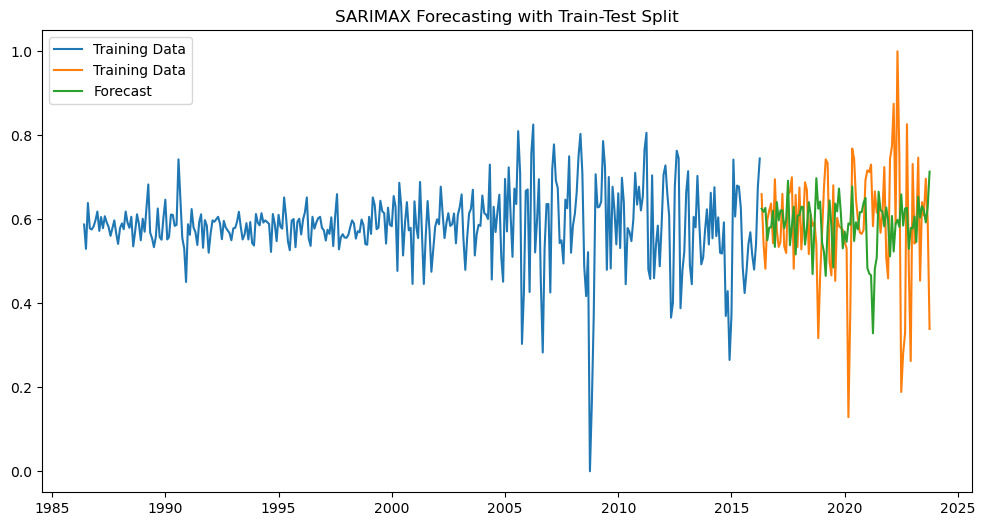

In [82]:
model_sarimax = SARIMAX(sarimax_X_train, order=(1, 1, 1), seasonal_order=(2, 1, 1, 75))
model_sarimax_results = model_sarimax.fit()
forecast = model_sarimax_results.get_forecast(steps=len(sarimax_X_test))


predicted_values = forecast.predicted_mean

mean_predicted_value = predicted_values.mean()

print("Mean of predicted values:", mean_predicted_value)

plt.figure(figsize=(12, 6))
plt.plot(sarimax_X_train, label='Training Data')
plt.plot(sarimax_X_test, label='Training Data')
plt.plot(predicted_values, label='Forecast')
plt.title('SARIMAX Forecasting with Train-Test Split')
plt.legend()
plt.show()

In [83]:
rmse_sarimax = sqrt(mean_squared_error(sarimax_X_test, predicted_values))

In [84]:
rmse_sarimax

0.1650544295953077

In [85]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_sarimax = mean_absolute_percentage_error(sarimax_X_test, predicted_values)

In [86]:
mape_sarimax

25.672189486526864

In [87]:
sarimax_X_test['predictions'] = predicted_values

C:\Users\Dell\AppData\Local\Temp\ipykernel_11816\1458194653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarimax_X_test['predictions'] = predicted_values


In [88]:
sarimax_X_test.head(10)

standardized  predictions
Month                                
2016-05-01      0.659868     0.625150
2016-06-01      0.542763     0.617699
2016-07-01      0.482237     0.627232
2016-08-01      0.598684     0.550310
2016-09-01      0.621053     0.580277
2016-10-01      0.637500     0.580760
2016-11-01      0.542763     0.620311
2016-12-01      0.695395     0.534201
2017-01-01      0.573026     0.640942
2017-02-01      0.534211     0.597240

## Exponential Smoothing

In [89]:
endog_series = gas['Dollars_per_Gallon']

In [90]:
seasonal_periods=12
model_2=ExponentialSmoothing(endog_series, seasonal='add', seasonal_periods=seasonal_periods)
result_exp=model_2.fit()

n_periods = 20 
forecast = result_exp.forecast(steps=n_periods)

forecast

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-11-01    2.464431
2023-12-01    2.397977
2024-01-01    2.432216
2024-02-01    2.462677
2024-03-01    2.517152
2024-04-01    2.587310
2024-05-01    2.619394
2024-06-01    2.607656
2024-07-01    2.600518
2024-08-01    2.595852
2024-09-01    2.576958
2024-10-01    2.524000
2024-11-01    2.464431
2024-12-01    2.397977
2025-01-01    2.432216
2025-02-01    2.462677
2025-03-01    2.517152
2025-04-01    2.587310
2025-05-01    2.619394
2025-06-01    2.607656
Freq: MS, dtype: float64

In [91]:
forecast1 = result_exp.forecast(steps=len(endog_series))

rmse_exp = np.sqrt(mean_squared_error(endog_series, forecast1))
print(f"Root Mean Squared Error (RMSE): {rmse_exp}")

Root Mean Squared Error (RMSE): 1.4472887190608792


In [92]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_exp = mean_absolute_percentage_error(endog_series, forecast1)
print(f"Mean Absolute Percentage Error (MAPE): {mape_exp:.2f}%")

Mean Absolute Percentage Error (MAPE): nan%


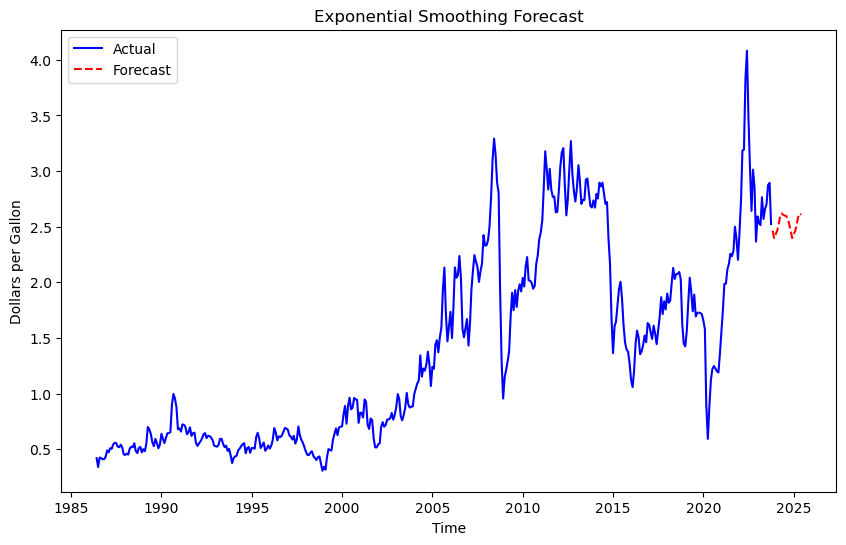

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(endog_series.index, endog_series, label='Actual', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='dashed', color='red')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Time')
plt.ylabel('Dollars per Gallon')
plt.legend()
plt.show()

## Auto-ARIMA

In [94]:
gas_seasonal = gas_new
gas_y_hist = gas_seasonal.loc['1986':'2021','Dollar_Diff'] 
gas_y_future = gas_seasonal.loc['2022':, 'Dollar_Diff']
gas_y_hist, gas_y_future

(Month
 1986-06-01    0.008
 1986-07-01   -0.080
 1986-08-01    0.086
 1986-09-01   -0.006
 1986-10-01   -0.010
               ...  
 2021-08-01   -0.022
 2021-09-01    0.049
 2021-10-01    0.216
 2021-11-01   -0.110
 2021-12-01   -0.187
 Name: Dollar_Diff, Length: 427, dtype: float64,
 Month
 2022-01-01    0.246
 2022-02-01    0.290
 2022-03-01    0.445
 2022-04-01    0.009
 2022-05-01    0.635
 2022-06-01    0.254
 2022-07-01   -0.598
 2022-08-01   -0.457
 2022-09-01   -0.385
 2022-10-01    0.371
 2022-11-01   -0.161
 2022-12-01   -0.486
 2023-01-01    0.227
 2023-02-01   -0.061
 2023-03-01   -0.017
 2023-04-01    0.250
 2023-05-01   -0.195
 2023-06-01    0.089
 2023-07-01    0.041
 2023-08-01    0.174
 2023-09-01    0.020
 2023-10-01   -0.370
 Name: Dollar_Diff, dtype: float64)

In [95]:
gas_seasonal

Dollar_Diff
Month                  
1986-06-01        0.008
1986-07-01       -0.080
1986-08-01        0.086
1986-09-01       -0.006
1986-10-01       -0.010
...                 ...
2023-06-01        0.089
2023-07-01        0.041
2023-08-01        0.174
2023-09-01        0.020
2023-10-01       -0.370

[449 rows x 1 columns]

In [96]:
print(len(gas_y_hist))
print(260*5)     #(260 trading days in a year)This multiplication seems to aim for 5 years 
print(np.where(gas_y_hist<=0))

427
1300
(array([  1,   3,   4,   8,  10,  13,  14,  15,  17,  18,  19,  21,  24,
        26,  27,  30,  32,  35,  36,  37,  38,  40,  41,  44,  45,  52,
        53,  54,  56,  58,  59,  60,  63,  66,  67,  73,  75,  76,  77,
        78,  79,  80,  83,  84,  85,  87,  89,  90,  99, 102, 104, 105,
       108, 109, 112, 115, 119, 120, 122, 126, 127, 128, 129, 130, 132,
       135, 136, 137, 138, 139, 140, 141, 144, 145, 146, 149, 150, 152,
       155, 156, 160, 166, 169, 172, 173, 174, 176, 177, 179, 180, 181,
       183, 184, 185, 186, 191, 197, 201, 202, 203, 207, 208, 216, 218,
       221, 222, 224, 227, 232, 233, 236, 239, 242, 243, 244, 247, 252,
       253, 254, 258, 265, 266, 267, 268, 269, 270, 277, 279, 282, 284,
       287, 288, 289, 290, 299, 300, 302, 303, 305, 311, 312, 316, 317,
       318, 321, 322, 324, 327, 328, 329, 331, 333, 335, 337, 338, 340,
       341, 342, 343, 349, 350, 351, 352, 353, 354, 355, 356, 360, 361,
       365, 367, 368, 369, 371, 372, 376, 378, 380, 38

In [97]:
gas_y_hist= np.abs(gas_y_hist)

In [98]:
with StepwiseContext(max_dur=25):
    auto_arima_model = auto_arima(y=gas_y_hist,
                                seasonal=True, 
                                stationary = True,                            
                                information_criterion="aic",
                                stepwise=True,
                                parallel=True,
                                trace=True,
                                m=22,
                                with_intercept = True,
                                random_state = 42,
                                n_jobs=3,start_p = 2,
                                max_p = 5,start_q = 0,
                                max_q = 2,
                                max_P = 1, max_Q = 1
                                )
gas_order = auto_arima_model.get_params().get("order")

Performing stepwise search to minimize aic


C:\Users\Dell\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,0)(1,0,1)[22] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,0)(0,0,0)[22] intercept   : AIC=-729.403, Time=0.16 sec
 ARIMA(1,0,0)(1,0,0)[22] intercept   : AIC=-841.323, Time=1.12 sec
 ARIMA(0,0,1)(0,0,1)[22] intercept   : AIC=-809.023, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[22]             : AIC=-467.469, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[22] intercept   : AIC=-841.894, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[22] intercept   : AIC=-841.298, Time=1.04 sec
 ARIMA(1,0,0)(1,0,1)[22] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(2,0,0)(0,0,0)[22] intercept   : AIC=-847.730, Time=0.24 sec
 ARIMA(2,0,0)(1,0,0)[22] intercept   : AIC=-846.734, Time=1.51 sec
 ARIMA(2,0,0)(0,0,1)[22] intercept   : AIC=-846.742, Time=0.76 sec
 ARIMA(3,0,0)(0,0,0)[22] intercept   : AIC=-846.117, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[22] intercept   : AIC=-866.216, Time=0.60 sec
 ARIMA(2,0,1)(1,0,0)[22] intercept   : AIC=-850.587, Time=1.77 sec
 ARIMA(2,0,1)(0,0,1)[22] intercept   : AIC=-865.327, Time=1.81 sec
 ARIM

C:\Users\Dell\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:326: UserWarning: early termination of stepwise search due to max_dur threshold (33.887 > 25.000)
  warnings.warn('early termination of stepwise search due to '


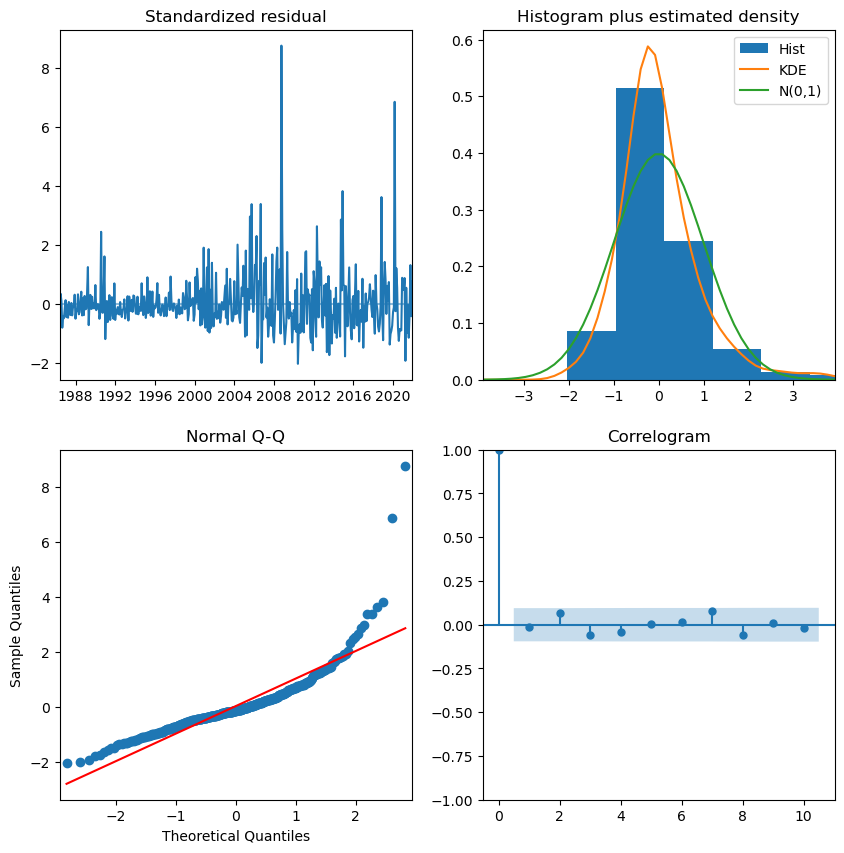

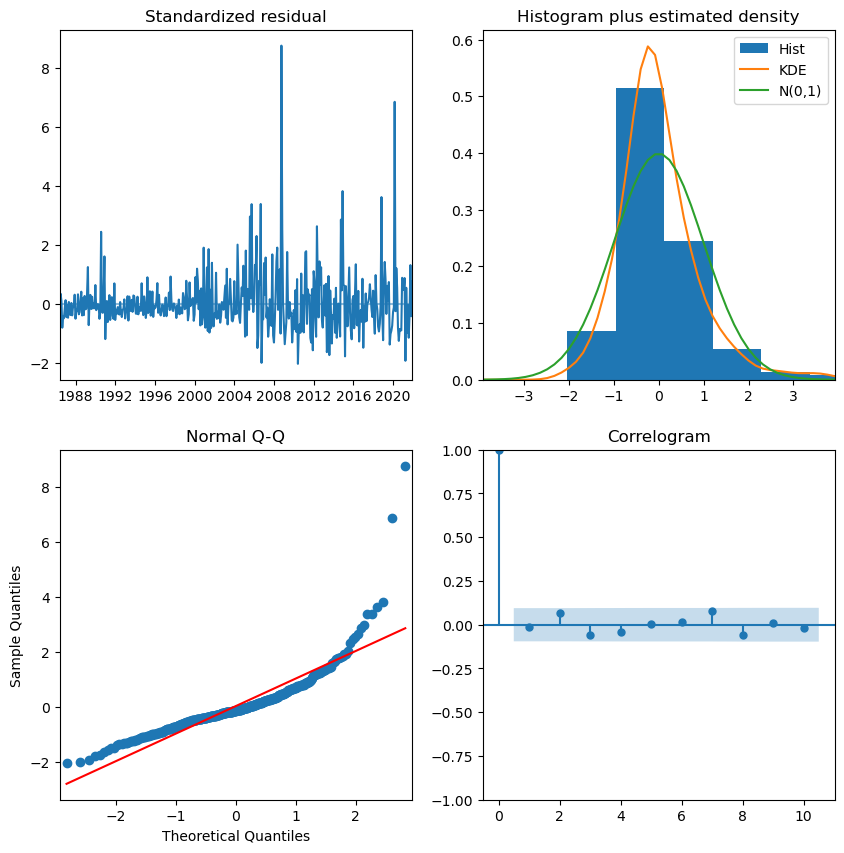

In [99]:
auto_arima_model.plot_diagnostics(figsize=(10,10))

In [100]:
cv_autoarima = model_selection.SlidingWindowForecastCV(h=10, 
                                                 step=(10),         #can also be considered as cycle of forecasting
                                                 window_size=(100*2)
                                                 )

cv_score = model_selection.cross_val_score(estimator = auto_arima_model,
                                           y = gas_y_hist,
                                           scoring = 'mean_squared_error',
                                           cv = cv_autoarima,
                                           verbose = 2,
                                           error_score= 100000000)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [101]:
gas_new.squeeze()

Month
1986-06-01    0.008
1986-07-01   -0.080
1986-08-01    0.086
1986-09-01   -0.006
1986-10-01   -0.010
              ...  
2023-06-01    0.089
2023-07-01    0.041
2023-08-01    0.174
2023-09-01    0.020
2023-10-01   -0.370
Name: Dollar_Diff, Length: 449, dtype: float64

In [102]:
gas_series = gas_new.squeeze()
date_index = gas_series.index
cv_generator = cv_autoarima.split(gas_series.index)# generates indices splits according to the sliding window
preds_df = []

for train,test in cv_generator:
    auto_arima_model.fit(gas_series.take(train))
    temp_gas_pred_df = pd.DataFrame(index=date_index[test])
    temp1 = auto_arima_model.predict(n_periods=len(test))
    temp_gas_pred_df['Predictions']=temp1
    temp_gas_pred_df['Dollar_Diff']=gas_series[test]
    preds_df.append(temp_gas_pred_df)

In [103]:
preds_df

[            Predictions  Dollar_Diff
 Month                               
 2003-02-01    -0.015107        0.117
 2003-03-01    -0.009450       -0.041
 2003-04-01     0.007137       -0.156
 2003-05-01     0.001624       -0.039
 2003-06-01     0.001447        0.048
 2003-07-01     0.002657        0.065
 2003-08-01     0.002322        0.134
 2003-09-01     0.002272       -0.104
 2003-10-01     0.002358       -0.028
 2003-11-01     0.002339        0.007,
             Predictions  Dollar_Diff
 Month                               
 2003-12-01    -0.006441        0.003
 2004-01-01     0.007147        0.113
 2004-02-01     0.003407        0.049
 2004-03-01     0.001732        0.044
 2004-04-01     0.002225        0.028
 2004-05-01     0.002040        0.225
 2004-06-01     0.001878       -0.191
 2004-07-01     0.001869        0.072
 2004-08-01     0.001849       -0.019
 2004-09-01     0.001832        0.055,
             Predictions  Dollar_Diff
 Month                               
 2004-10-0

In [104]:
# length of the forecast test period
f = len(gas_y_future)
f

22

In [105]:
gas_y_forecast = result.trend
gas_y_forecast

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
444   NaN
445   NaN
446   NaN
447   NaN
448   NaN
Name: trend, Length: 449, dtype: float64

In [106]:
result = seasonal_decompose(gas['Dollars_per_Gallon'], model='multiplicative', period=50)

In [107]:
gas_y_forecast = result.trend
gas_y_forecast = pd.concat([gas_y_forecast, gas_y_future])
gas_y_forecast[-f:] = np.NaN
gas_y_forecast.interpolate(method='linear',inplace=True)
gas_y_forecast = gas_y_forecast[-f:]

In [108]:
gas_y_forecast

Month
2022-01-01    2.1915
2022-02-01    2.1915
2022-03-01    2.1915
2022-04-01    2.1915
2022-05-01    2.1915
2022-06-01    2.1915
2022-07-01    2.1915
2022-08-01    2.1915
2022-09-01    2.1915
2022-10-01    2.1915
2022-11-01    2.1915
2022-12-01    2.1915
2023-01-01    2.1915
2023-02-01    2.1915
2023-03-01    2.1915
2023-04-01    2.1915
2023-05-01    2.1915
2023-06-01    2.1915
2023-07-01    2.1915
2023-08-01    2.1915
2023-09-01    2.1915
2023-10-01    2.1915
dtype: float64

In [109]:
gas_y_forecast.index

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [110]:
gas_y_forecast_df = gas_y_forecast.to_frame()
gas_y_forecast_df.rename(columns={0:'predicted_price'},inplace=True)
gas_y_forecast_df['price'] = gas_y_future

In [111]:
seasonal_decompose_metrics_df = {}
seasonal_decompose_metrics_df['gas_forecast_rmse'] = mean_squared_error(gas_y_forecast_df['price'],gas_y_forecast_df['predicted_price'],squared=False)
seasonal_decompose_metrics_df['gas_forecast_mse'] = mean_squared_error(gas_y_forecast_df['price'],gas_y_forecast_df['predicted_price'],squared=True)

(array([ 3652.,  5479.,  7305.,  9131., 10957., 12784., 14610., 16436.,
        18262., 20089.]),
 [Text(3652.0, 0, '1980'),
  Text(5479.0, 0, '1985'),
  Text(7305.0, 0, '1990'),
  Text(9131.0, 0, '1995'),
  Text(10957.0, 0, '2000'),
  Text(12784.0, 0, '2005'),
  Text(14610.0, 0, '2010'),
  Text(16436.0, 0, '2015'),
  Text(18262.0, 0, '2020'),
  Text(20089.0, 0, '2025')])

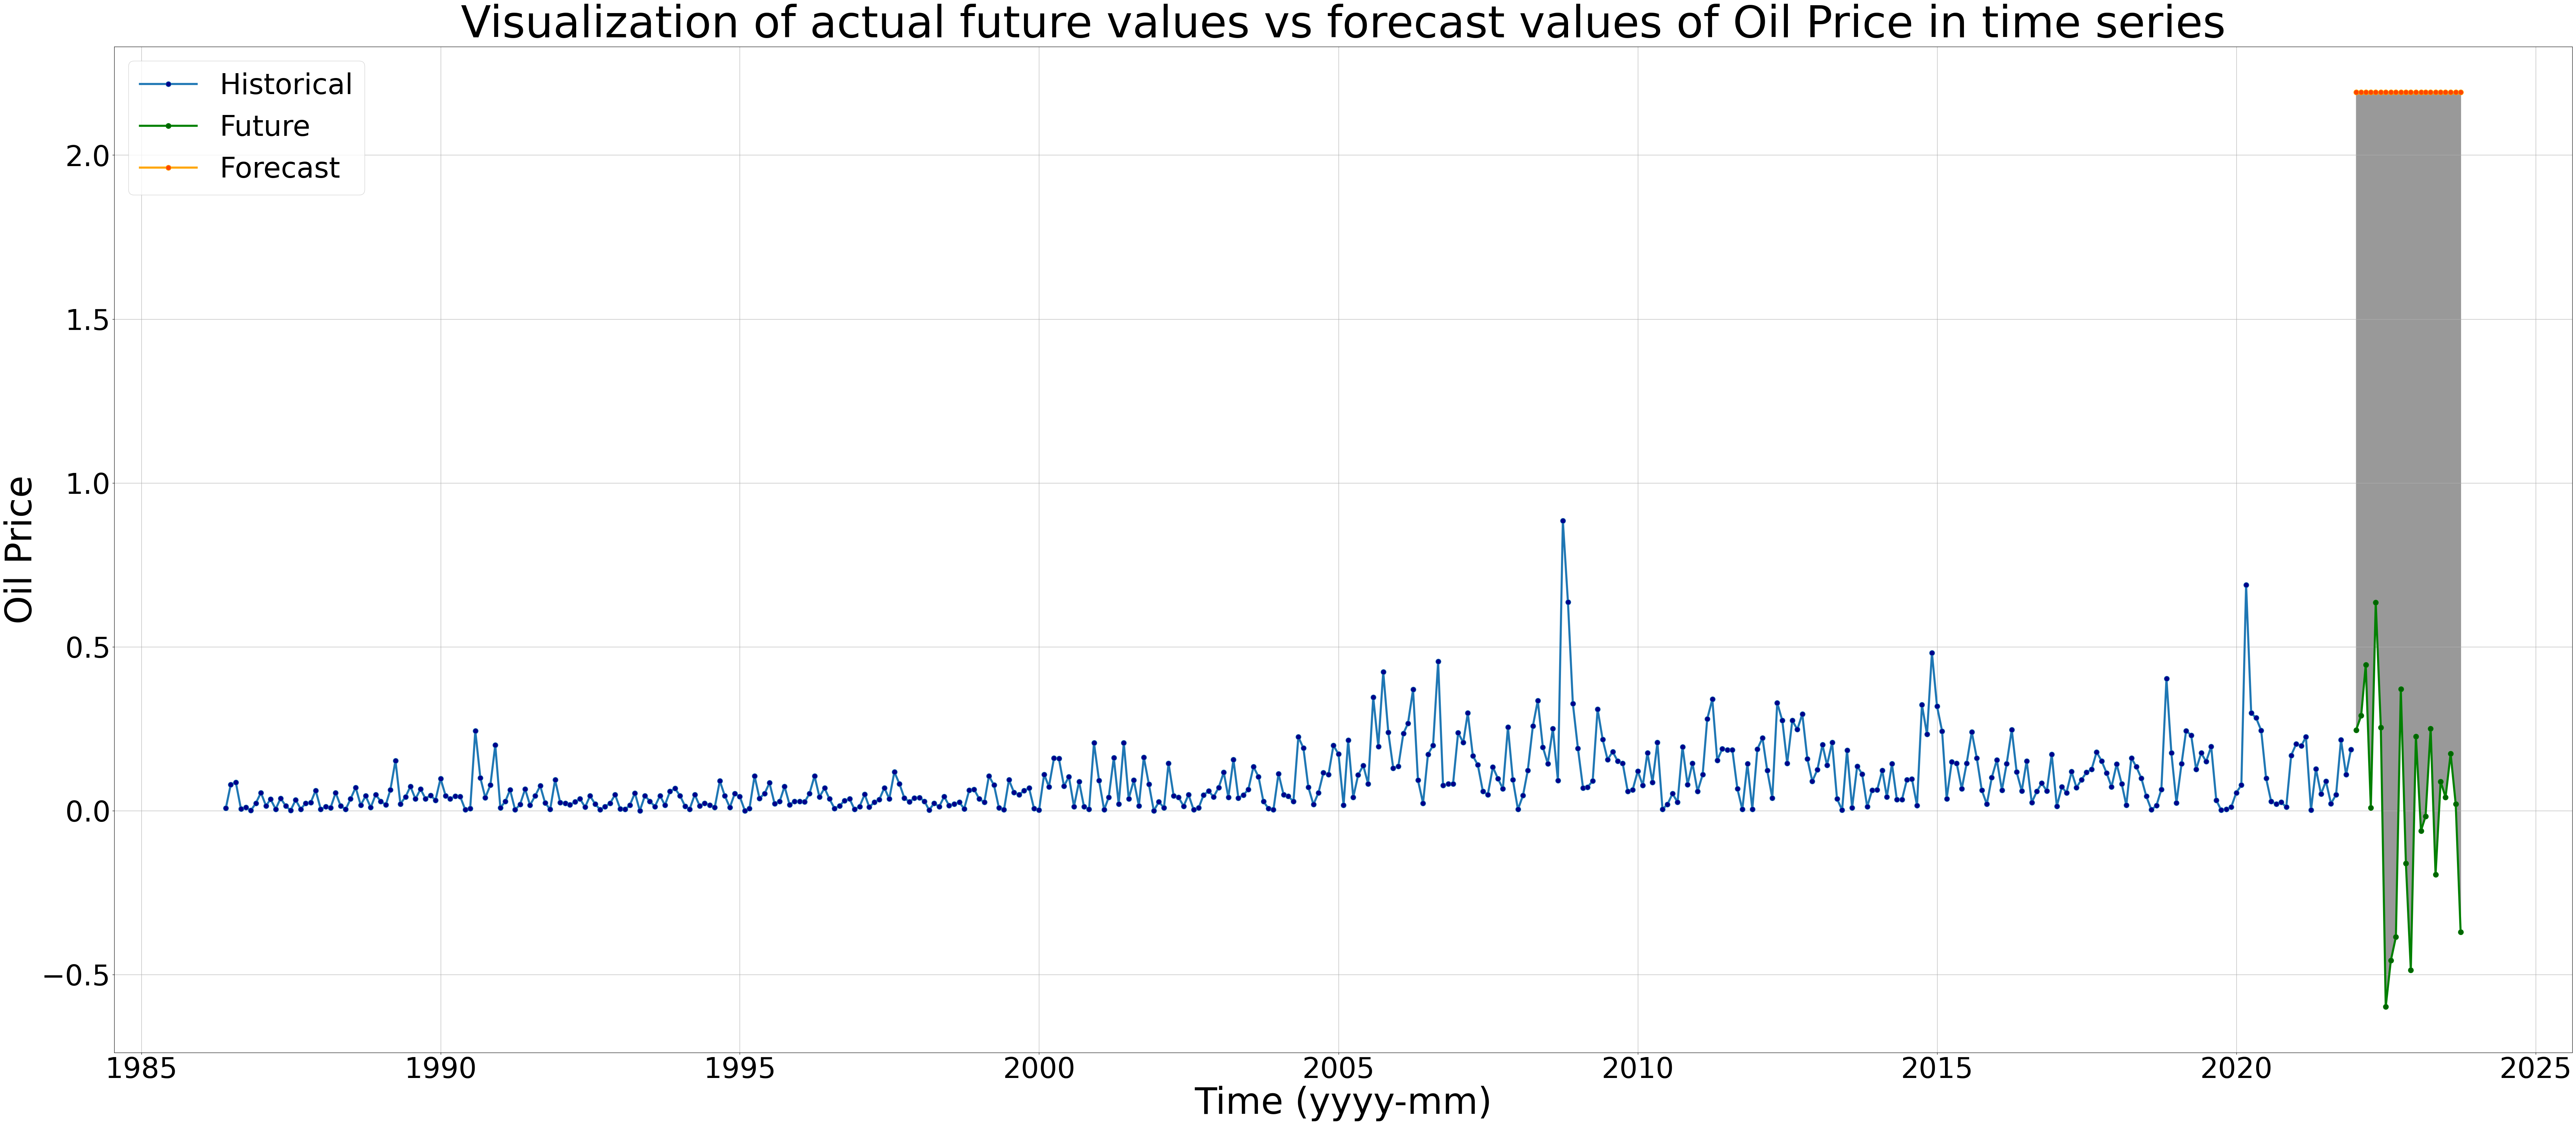

In [112]:
# Ploting the forecast vs Actual values
fig = plt.figure(figsize=(85,35))
ax = fig.add_subplot() # nrows, ncols, index

plt.plot(gas_y_hist,    
         markersize=20,linewidth=4,
         markerfacecolor= 'darkblue',
         marker='.',label='Historical')

plt.plot(gas_y_future,    
         markersize=20,linewidth=4,
         markerfacecolor= 'darkgreen',
         marker='.',
        color='green',label='Future')

plt.plot(gas_y_forecast,    
         markersize=20,linewidth=4,
         markerfacecolor= 'orangered',
         marker='.',
        color='orange',label='Forecast')

plt.fill_between(gas_y_forecast.index, gas_y_forecast, gas_y_future,color=(0.6,0.6,0.6))
plt.legend(fontsize=55)
plt.grid()
plt.xlabel('Time (yyyy-mm)', fontsize= 70)
plt.ylabel('Oil Price', fontsize= 70)
plt.title('Visualization of actual future values vs forecast values of Oil Price in time series', fontsize=85)
plt.yticks(fontsize=55)
plt.xticks(fontsize=55)
# plt.savefig('ts_forecast.png')

(array([18993., 19083., 19174., 19266., 19358., 19448., 19539., 19631.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10')])

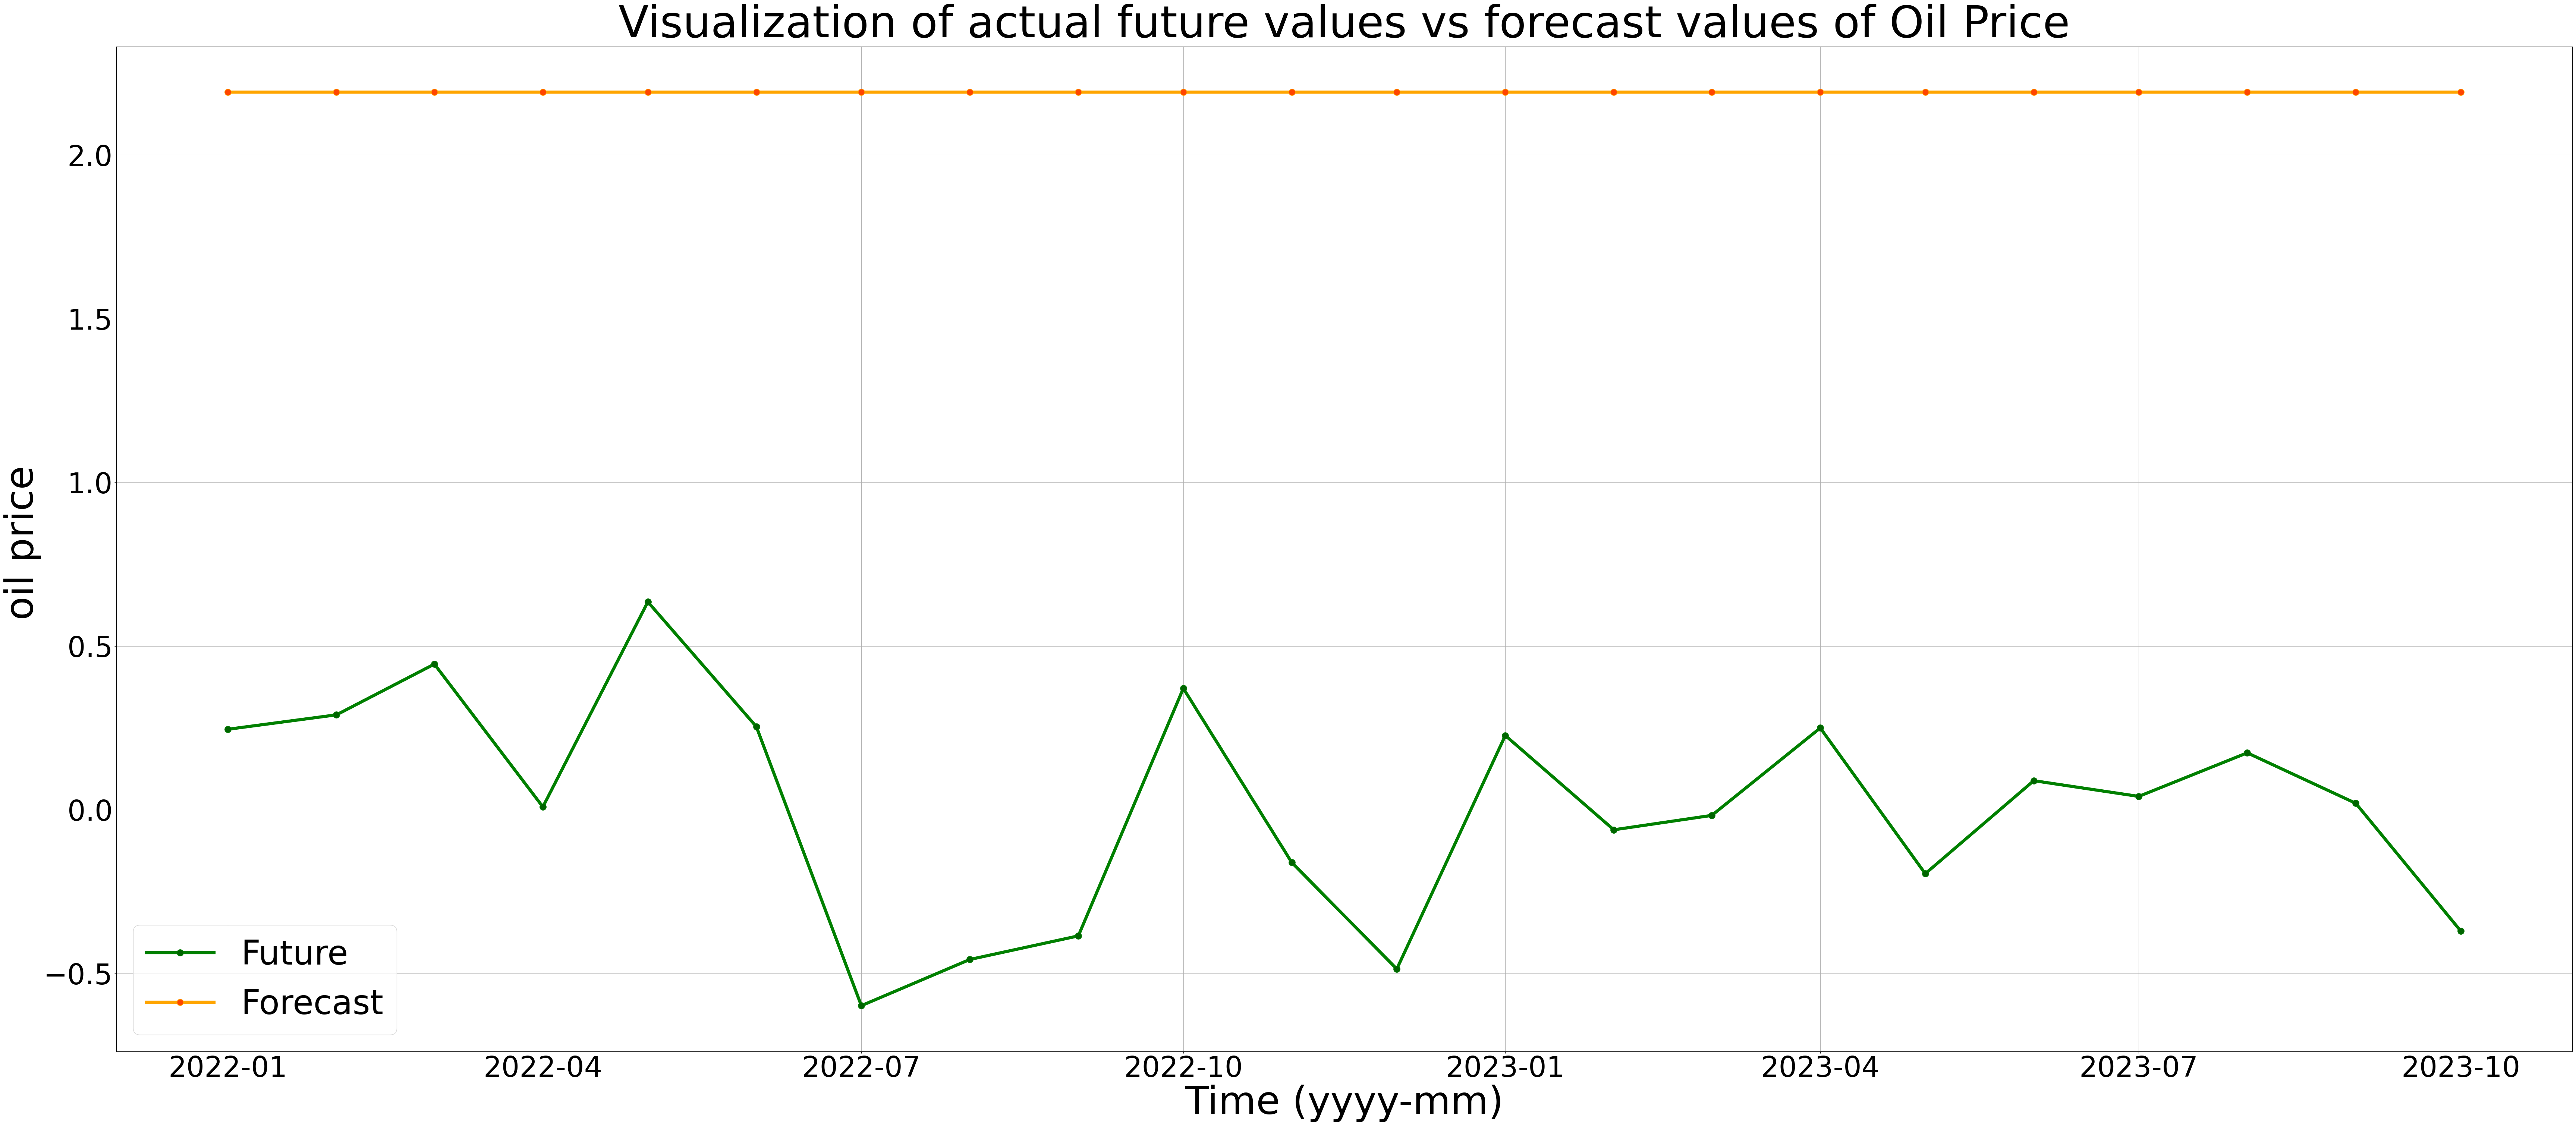

In [113]:
# Visualisation of future value (development data) vs forecast value
fig = plt.figure(figsize=(85,35))
ax = fig.add_subplot()

plt.plot(gas_y_future,    
         markersize=25,linewidth=6,
         markerfacecolor= 'darkgreen',
         marker='.',
        color='green',label='Future')

plt.plot(gas_y_forecast,    
         markersize=25,linewidth=6,
         markerfacecolor= 'orangered',
         marker='.',
        color='orange',label='Forecast')

#plt.fill_between(y_forecast.index, y_forecast, y_future,color=(0.6,0.6,0.6))
plt.legend(fontsize=65)
plt.grid()
plt.xlabel('Time (yyyy-mm)', fontsize= 75)
plt.ylabel(' oil price', fontsize= 75)
plt.title('Visualization of actual future values vs forecast values of Oil Price', fontsize=85)
plt.yticks(fontsize=55)
plt.xticks(fontsize=55)
# plt.savefig('forecast_future.png')

In [114]:
error_auto_arima = np.sqrt(np.average(cv_score))

In [115]:
error_auto_arima

0.12968947013798648

In [116]:
# get predictions on the test data(future data)
gas_y_forecast_auto_arima = pd.DataFrame(index=gas_y_future.index)
temp1 = auto_arima_model.predict(n_periods=22)
gas_y_forecast_auto_arima['predicted_price']=temp1.values
gas_y_forecast_auto_arima['price'] = gas_y_future

(array([18993., 19083., 19174., 19266., 19358., 19448., 19539., 19631.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04'),
  Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10')])

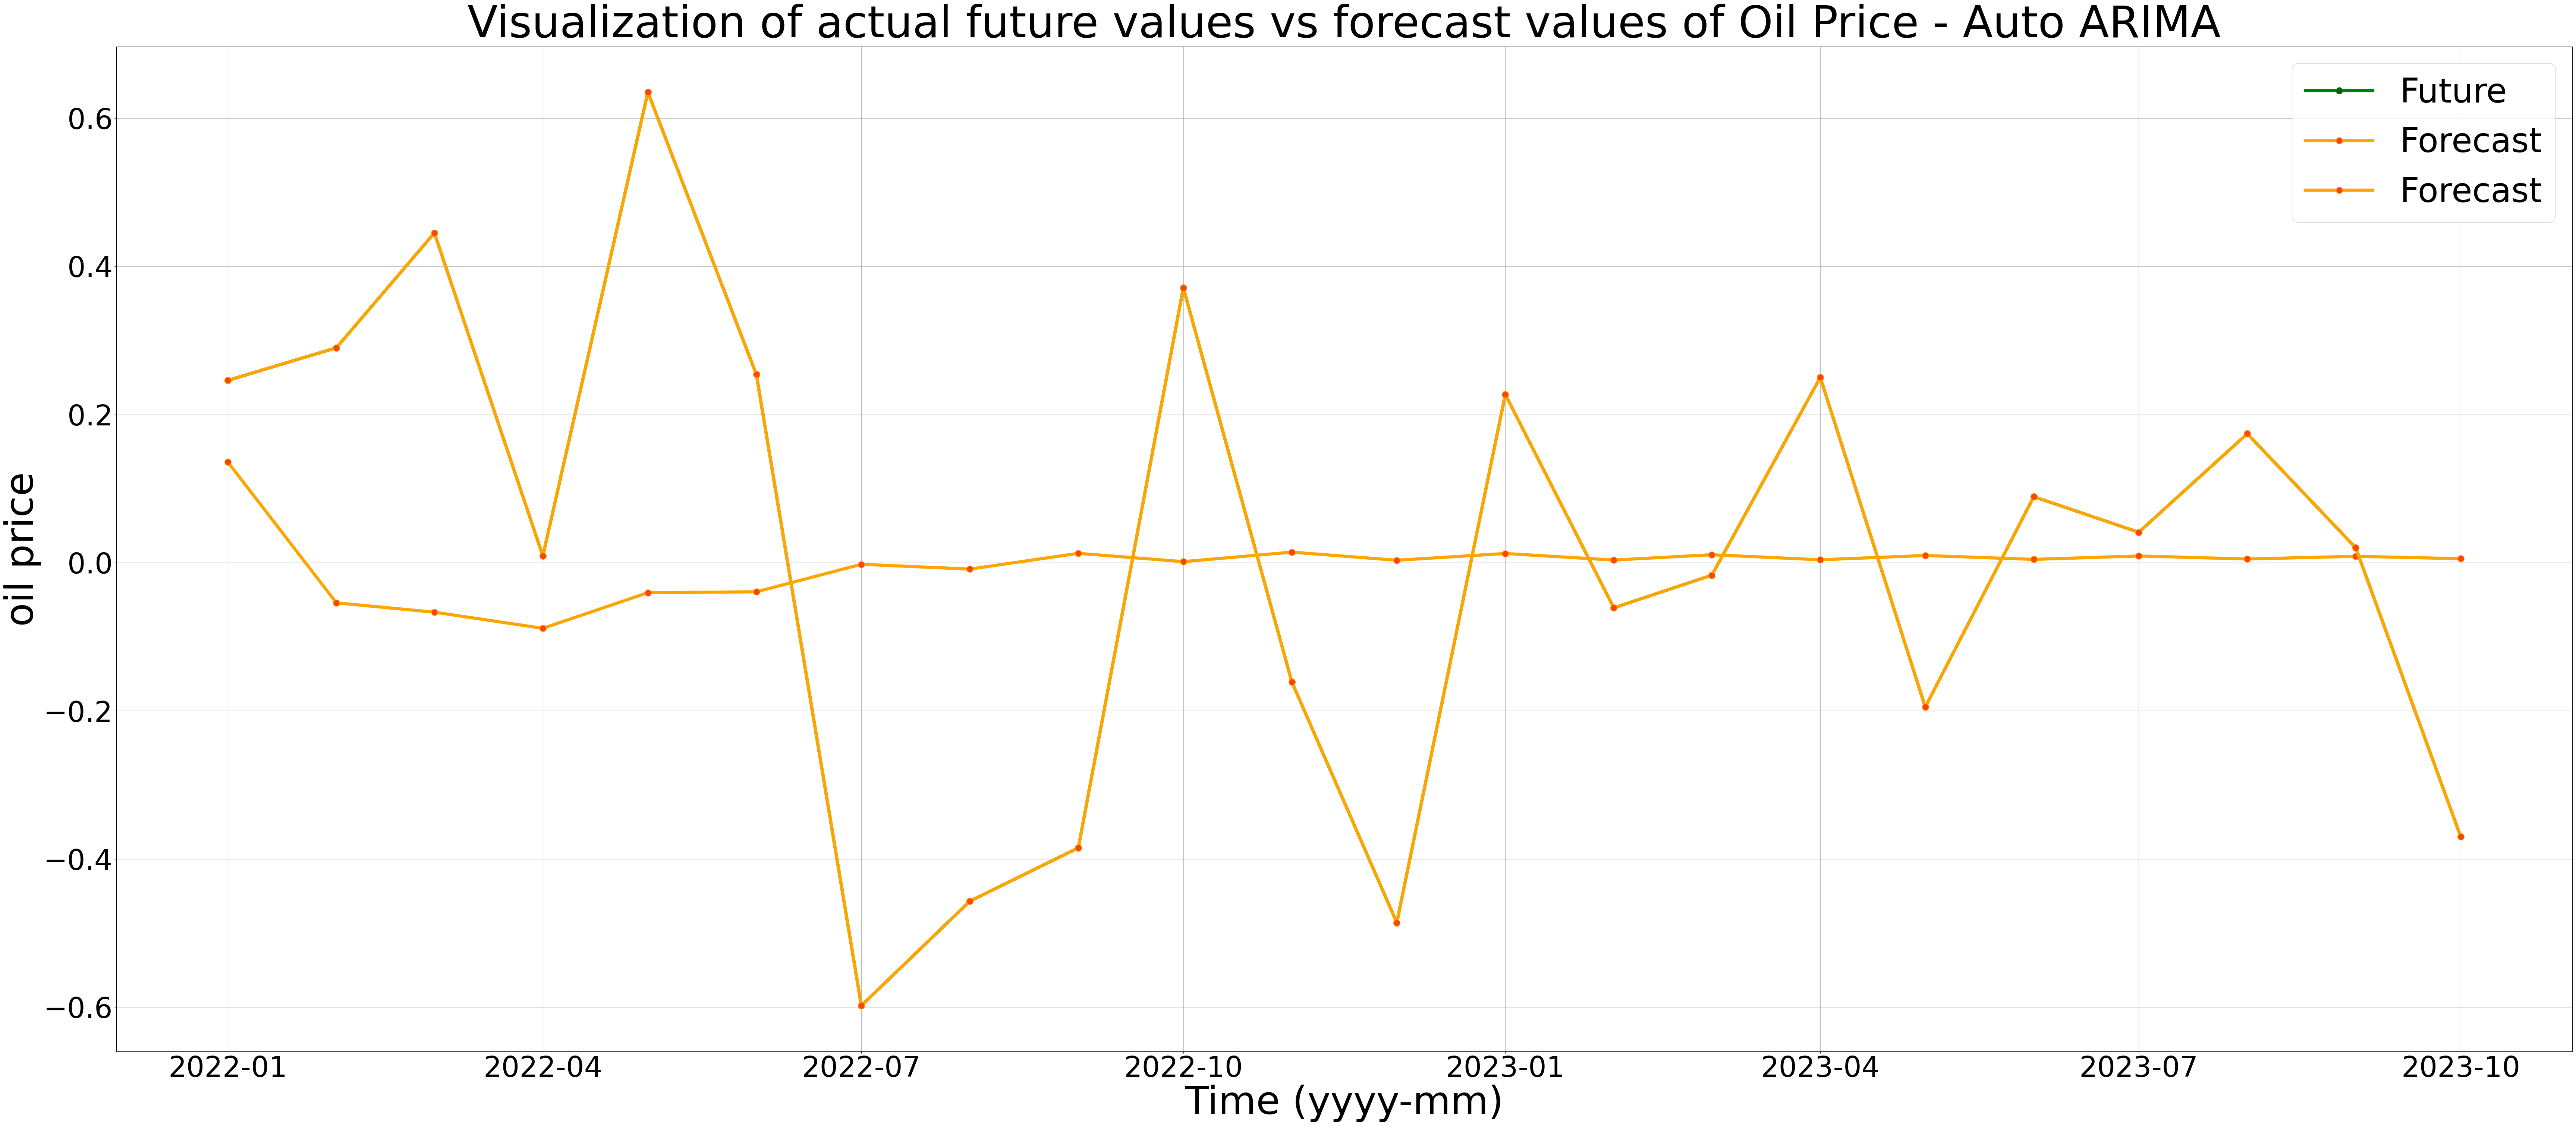

In [117]:
# Visualisation of future value (development data) vs forecast value
fig = plt.figure(figsize=(85,35))
ax = fig.add_subplot()

plt.plot(gas_y_future,    
         markersize=25,linewidth=6,
         markerfacecolor= 'darkgreen',
         marker='.',
        color='green',label='Future')

plt.plot(gas_y_forecast_auto_arima,    
         markersize=25,linewidth=6,
         markerfacecolor= 'orangered',
         marker='.',
        color='orange',label='Forecast')

#plt.fill_between(y_forecast.index, y_forecast, y_future,color=(0.6,0.6,0.6))
plt.legend(fontsize=65)
plt.grid()
plt.xlabel('Time (yyyy-mm)', fontsize= 75)
plt.ylabel('oil price', fontsize= 75)
plt.title('Visualization of actual future values vs forecast values of Oil Price - Auto ARIMA', fontsize=85)
plt.yticks(fontsize=55)
plt.xticks(fontsize=55)
# plt.savefig('forecast_future.png')

In [118]:
auto_arima_metrics_df = {}
auto_arima_metrics_df['gas_forecast_rmse'] = mean_squared_error(gas_y_forecast_auto_arima['price'],gas_y_forecast_auto_arima['predicted_price'],squared=False)
auto_arima_metrics_df['gas_forecast_mse'] = mean_squared_error(gas_y_forecast_auto_arima['price'],gas_y_forecast_auto_arima['predicted_price'],squared=True)

Text(0.5, 1.0, 'oil price prediction using ARIMA for 10 days.')

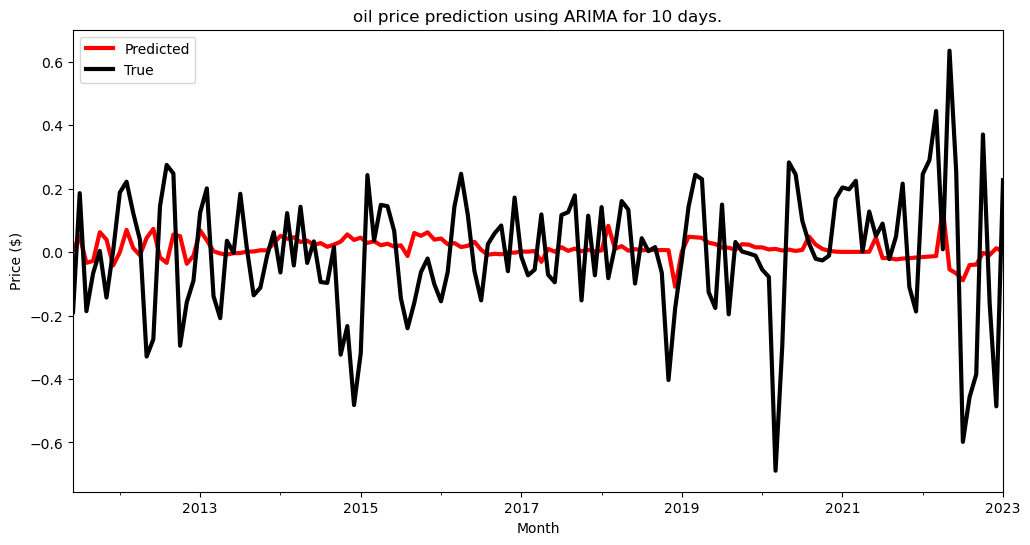

In [119]:

## Visualization of the CV SARIMA model prediction on the training data, development and test data
pd.concat(preds_df[10:]).plot(figsize=(12,6),lw=3,color=['r','k'])
plt.legend(('Predicted','True'))
plt.ylabel('Price ($)')
plt.title('oil price prediction using ARIMA for 10 days.')

In [120]:
preds_df

[            Predictions  Dollar_Diff
 Month                               
 2003-02-01    -0.015107        0.117
 2003-03-01    -0.009450       -0.041
 2003-04-01     0.007137       -0.156
 2003-05-01     0.001624       -0.039
 2003-06-01     0.001447        0.048
 2003-07-01     0.002657        0.065
 2003-08-01     0.002322        0.134
 2003-09-01     0.002272       -0.104
 2003-10-01     0.002358       -0.028
 2003-11-01     0.002339        0.007,
             Predictions  Dollar_Diff
 Month                               
 2003-12-01    -0.006441        0.003
 2004-01-01     0.007147        0.113
 2004-02-01     0.003407        0.049
 2004-03-01     0.001732        0.044
 2004-04-01     0.002225        0.028
 2004-05-01     0.002040        0.225
 2004-06-01     0.001878       -0.191
 2004-07-01     0.001869        0.072
 2004-08-01     0.001849       -0.019
 2004-09-01     0.001832        0.055,
             Predictions  Dollar_Diff
 Month                               
 2004-10-0

In [121]:
gas_cv_rmse = []
gas_cv_mse = []
for df in preds_df:
    gas_cv_rmse.append(mean_squared_error(df['Dollar_Diff'],df['Predictions'],squared=False))
    gas_cv_mse.append(mean_squared_error(df['Dollar_Diff'],df['Predictions'],squared=True))

In [122]:
gas_cv_metrics_df = {}

gas_cv_metrics_df['gas_cv_forecast_rmse'] = gas_cv_rmse
gas_cv_metrics_df['gas_cv_forecast_mse'] = gas_cv_mse

gas_cv_metrics_df = pd.DataFrame.from_dict(gas_cv_metrics_df,orient='index')


## LSTM Model

In [123]:
gas_new = gas.drop(columns='Dollars_per_Gallon')

In [124]:
train = gas_new.iloc[:400]
test = gas_new.iloc[400:]

In [125]:
gas_new.head(), gas_new.tail()

(            Dollar_Diff
 Month                  
 1986-06-01        0.008
 1986-07-01       -0.080
 1986-08-01        0.086
 1986-09-01       -0.006
 1986-10-01       -0.010,
             Dollar_Diff
 Month                  
 2023-06-01        0.089
 2023-07-01        0.041
 2023-08-01        0.174
 2023-09-01        0.020
 2023-10-01       -0.370)

In [126]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [127]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [128]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.71155378 0.64143426 0.77370518]
Predict this y: 
 [[0.70039841]]


In [129]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [130]:
# define model
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [131]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [132]:
# fit model
model_lstm.fit(generator,epochs=50)

Epoch 1/50

388/388 [==============================] - 4s 5ms/step - loss: 0.0272
Epoch 2/50
388/388 [==============================] - 2s 5ms/step - loss: 0.0150
Epoch 3/50
388/388 [==============================] - 2s 5ms/step - loss: 0.0139
Epoch 4/50
388/388 [==============================] - 2s 5ms/step - loss: 0.0136
Epoch 5/50
388/388 [==============================] - 2s 6ms/step - loss: 0.0134
Epoch 6/50
388/388 [==============================] - 2s 6ms/step - loss: 0.0130
Epoch 7/50
388/388 [==============================] - 2s 6ms/step - loss: 0.0130
Epoch 8/50
388/388 [==============================] - 2s 6ms/step - loss: 0.0129
Epoch 9/50
388/388 [==============================] - 2s 6ms/step - loss: 0.0121
Epoch 10/50
388/388 [==============================] - 2s 5ms/step - loss: 0.0123
Epoch 11/50
388/388 [==============================] - 2s 5ms/step - loss: 0.0124
Epoch 12/50
388/388 [==============================] - 2s 6ms/step - loss: 0.0116
Epoch 13/50
388/388 [===

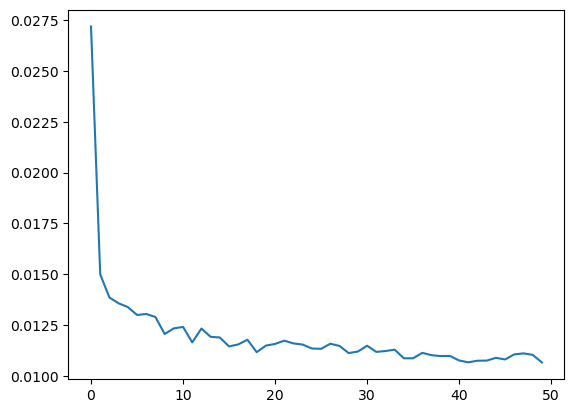

In [133]:
loss_per_epoch = model_lstm.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [134]:
last_train_batch = scaled_train[-12:]

In [135]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [136]:
model_lstm.predict(last_train_batch)

1/1 [==============================] - 0s 268ms/step


array([[0.77233684]], dtype=float32)

In [137]:
scaled_test[0]

array([0.70677291])

In [138]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model_lstm.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 31ms/step


In [139]:
test_predictions

[array([0.77233684], dtype=float32),
 array([0.73291796], dtype=float32),
 array([0.73968947], dtype=float32),
 array([0.7365147], dtype=float32),
 array([0.7409446], dtype=float32),
 array([0.74278295], dtype=float32),
 array([0.74163634], dtype=float32),
 array([0.73097074], dtype=float32),
 array([0.72615516], dtype=float32),
 array([0.73271227], dtype=float32),
 array([0.727344], dtype=float32),
 array([0.72983795], dtype=float32),
 array([0.7332966], dtype=float32),
 array([0.7325876], dtype=float32),
 array([0.7325303], dtype=float32),
 array([0.7325071], dtype=float32),
 array([0.7326437], dtype=float32),
 array([0.732796], dtype=float32),
 array([0.7326998], dtype=float32),
 array([0.7322433], dtype=float32),
 array([0.7319414], dtype=float32),
 array([0.7320479], dtype=float32),
 array([0.7319439], dtype=float32),
 array([0.7320055], dtype=float32),
 array([0.7321771], dtype=float32),
 array([0.7322082], dtype=float32),
 array([0.7322078], dtype=float32),
 array([0.7322087], d

In [140]:
test.head()

Dollar_Diff
Month                  
2019-10-01        0.002
2019-11-01       -0.004
2019-12-01       -0.011
2020-01-01       -0.055
2020-02-01       -0.078

In [141]:
true_predictions = scaler.inverse_transform(test_predictions)

<Axes: xlabel='Month'>

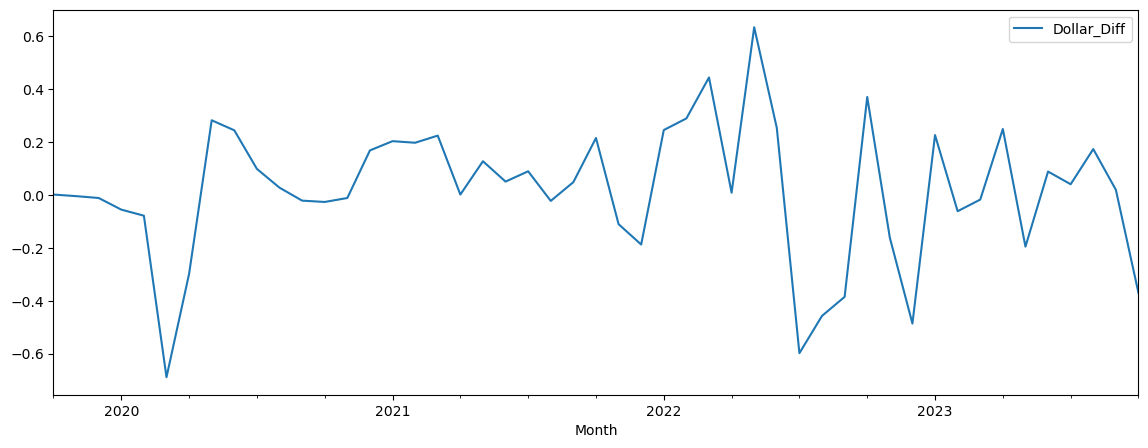

In [142]:
test.plot(figsize=(14,5))

In [143]:
test['Predictions'] = true_predictions
rmse=sqrt(mean_squared_error(test['Dollar_Diff'],test['Predictions']))
print(rmse)

0.2598859601534176


C:\Users\Dell\AppData\Local\Temp\ipykernel_11816\2836895605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


## FB-Prophet

In [144]:
gas_new = gas.drop(columns='Dollars_per_Gallon')
gas_new["Month"] = gas_new.index
gas_new = gas_new.rename(columns={"Month": "ds", "Dollar_Diff": "y"}, errors="raise")
gas_new.head()

y         ds
Month                       
1986-06-01  0.008 1986-06-01
1986-07-01 -0.080 1986-07-01
1986-08-01  0.086 1986-08-01
1986-09-01 -0.006 1986-09-01
1986-10-01 -0.010 1986-10-01

<Axes: xlabel='ds'>

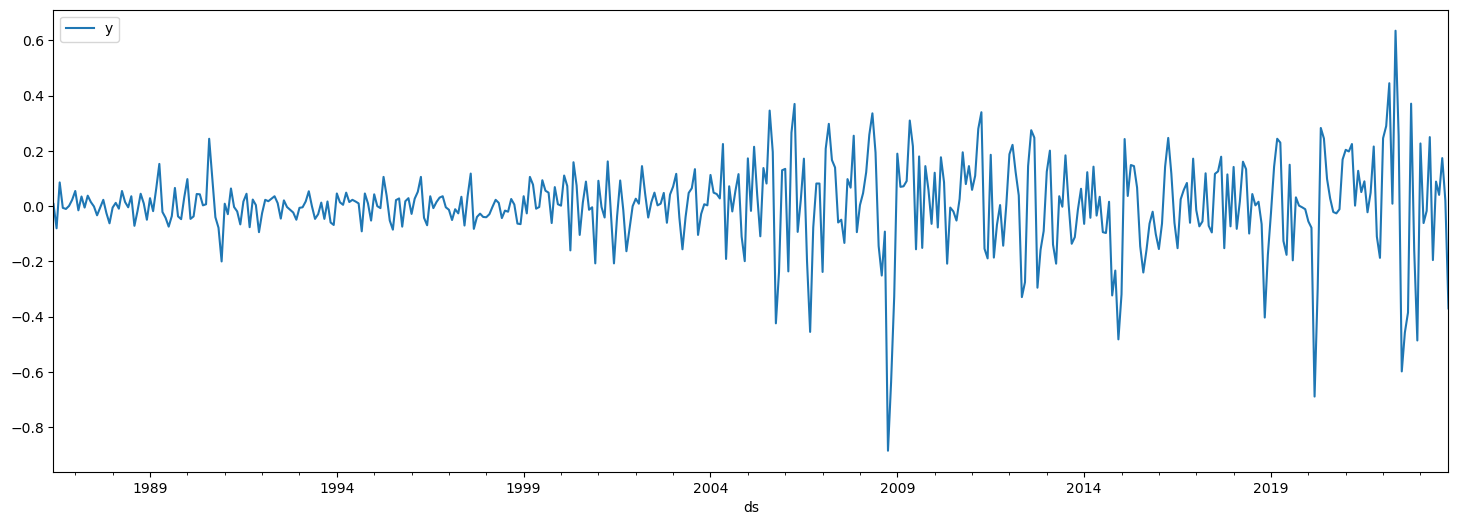

In [145]:
gas_new.plot(x='ds',y='y',figsize=(18,6))

In [146]:
train = gas_new.iloc[:len(gas_new)-365]
test = gas_new.iloc[len(gas_new)-365:]

In [147]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=365) #MS for monthly, H for hourly
forecast = m.predict(future)

15:58:22 - cmdstanpy - INFO - Chain [1] start processing
15:58:23 - cmdstanpy - INFO - Chain [1] done processing


In [148]:
forecast.tail()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
444 1994-04-27 -0.006694   -0.069606    0.051444    -0.006694    -0.006694   
445 1994-04-28 -0.006700   -0.071455    0.050666    -0.006700    -0.006700   
446 1994-04-29 -0.006706   -0.065589    0.052185    -0.006706    -0.006706   
447 1994-04-30 -0.006712   -0.061340    0.056319    -0.006712    -0.006712   
448 1994-05-01 -0.006718   -0.057100    0.063089    -0.006718    -0.006718   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
444       -0.000288             -0.000288             -0.000288 -0.000288   
445       -0.002565             -0.002565             -0.002565 -0.002565   
446       -0.001291             -0.001291             -0.001291 -0.001291   
447        0.003032              0.003032              0.003032  0.003032   
448        0.009803              0.009803              0.009803  0.009803   

     yearly_lower  yearly_upper  multiplicative_terms  \
444     -0.000288     -0.000288                   0.0   
445     -0.002565     -0.002565                   0.0   
446     -0.001291     -0.001291                   0.0   
447      0.003032      0.003032                   0.0   
448      0.009803      0.009803                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
444                         0.0                         0.0 -0.006982  
445                         0.0                         0.0 -0.009264  
446                         0.0                         0.0 -0.007996  
447                         0.0                         0.0 -0.003680  
448                         0.0                         0.0  0.003085

In [149]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
444 1994-04-27 -0.006982   -0.069606    0.051444
445 1994-04-28 -0.009264   -0.071455    0.050666
446 1994-04-29 -0.007996   -0.065589    0.052185
447 1994-04-30 -0.003680   -0.061340    0.056319
448 1994-05-01  0.003085   -0.057100    0.063089

In [150]:
test.tail()

y         ds
Month                       
2023-06-01  0.089 2023-06-01
2023-07-01  0.041 2023-07-01
2023-08-01  0.174 2023-08-01
2023-09-01  0.020 2023-09-01
2023-10-01 -0.370 2023-10-01

In [151]:
plot_plotly(m ,forecast)

In [152]:
plot_components_plotly(m, forecast)

In [153]:
predictions = forecast.iloc[-365:]['yhat']

Root Mean Squared Error between actual and  predicted values:  0.3749024925150875
Mean Value of Test Dataset: 0.005287671232876713

## Model Deployment 

In [156]:
import joblib

### Save the fitted SARIMAX model
model_filename = 'sarimax_model.joblib'
joblib.dump(model_sarimax_results, model_filename)

### Save any necessary information about the model configuration
config_filename = 'sarimax_config.joblib'
joblib.dump({'order': (1, 1, 1), 'seasonal_order': (2, 1, 1, 75)}, config_filename)

['sarimax_config.joblib']